# Before you get started

## Data formatting

MINER is optimized for expression data of the form log2(TPM+1) or log2(FPKM+1). Expression data in counts format is not currently supported. 

If expression data is not Homo Sapiens, a reference database must be provided for mechanistic inference.

## Data location

This tutorial will import data stored in the "miner/data" folder. Before you start, move your data to the "miner/data" folder. 

## Special dependencies

These dependencies are not required for coexpression clustering or mechanistic inference, but are employed for optional functions in the miner library

Survival analysis:
    install lifelines

# Begin miner analysis

## Import standard dependencies

In [1771]:
import numpy as np
import pandas as pd
from scipy import stats
from numpy import random as rd
import os
import json
from sklearn.decomposition import PCA
import multiprocessing, multiprocessing.pool
import matplotlib.pyplot as plt
import time
from collections import Counter
from sklearn.manifold import TSNE
import miner
%matplotlib inline

## Create directory to save output files

In [1772]:
# create name for results folder where output files will be saved
resultsFolder = "results_from_miner"

# create results directory
resultsDirectory = os.path.join(os.path.split(os.getcwd())[0],resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)


## Load input data into dataframe

In [1773]:
#expressionData = pd.read_csv(os.path.join("..","data","IA12Zscore.csv"),index_col=0,header=0)
expressionData = pd.read_table(os.path.join("..","data","single.cell.data.adrian.txt"),index_col=0,header=0)
#expressionData = pd.read_csv(os.path.join("..","data","gbmTCGA_exprMat_medianFiltered.csv"),index_col=0,header=0)
#expressionData = pd.read_csv(os.path.join("..","data","expressionDataRelapsed.csv"),index_col=0,header=0)

## Convert annotations (skip if samples are not Homo Sapiens)

In [1774]:
expressionData, conversionTable = miner.identifierConversion(expressionData)

completed identifier conversion.
1623 genes were converted.


## Pre-process expression data

In [1775]:
expressionData = miner.zscore(expressionData)

completed z-transformation.


## Load previous results (skip if results have not previously been generated)

In [1322]:
# If previous results exist, use miner.read_json to load them
revisedClusters = miner.read_json(os.path.join(resultsDirectory,"coexpressionDictionary.json"))
coexpressionModules = miner.read_json(os.path.join(resultsDirectory,"coexpressionModules.json"))
regulons = miner.read_json(os.path.join(resultsDirectory,"regulons.json"))
mechanisticOutput = miner.read_json(os.path.join(resultsDirectory,"mechanisticOutput.json"))

IOError: [Errno 2] No such file or directory: '/Users/MattWall/Desktop/miner/results_gbm_f1Clustering/coexpressionDictionary.json'

## Cluster expression data

In [1776]:
# define parameters
# bulk RNAseq analysis default: minNumberGenes = 6, minCorrelation = 0.2, minNumberRegulonGenes = 5
# single cell RNAseq analysis default: minNumberGenes = 6, minCorrelation = 0.05, minNumberRegulonGenes = 4

# minimum number of genes that form an acceptable coexpression cluster:
minNumberGenes = 6

# minimum correlation coefficient for an acceptable regulator-cluster association 
minCorrelation = 0.05

# minimum number of genes that form an acceptable coexpression cluster and have share binding site for regulator:
minNumberRegulonGenes = 4

In [1777]:
reload(miner)
# generate a list of coexpressed gene clusters, all of which have length >= minNumberGenes
initialClusters = miner.cluster(expressionData,minNumberGenes = minNumberGenes,minNumberOverExpSamples=4,maxSamplesExcluded=0.50,random_state=12,overExpressionThreshold=80) 
# revise initialClusters to combine highly correlated clusters and keep only those with significant coexpression
revisedClusters = miner.reviseInitialClusters(initialClusters,expressionData)
# write revisedClusters to .json file
miner.write_json(revisedClusters,os.path.join(resultsDirectory,"coexpressionDictionary.json"))

0.00 percent complete
20.00 percent complete
40.00 percent complete
60.00 percent complete
80.00 percent complete

coexpression clustering completed in 1.17 minutes


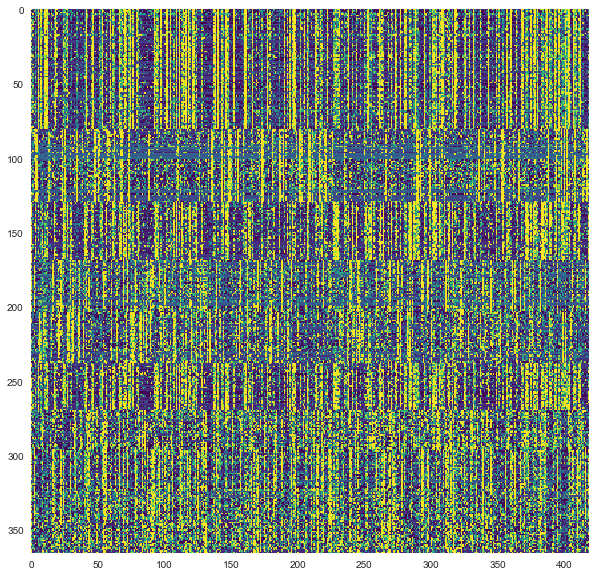

In [1778]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.grid(False)
plt.imshow(expressionData.loc[np.hstack([revisedClusters[i] for i in range(10)]),:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)

In [1779]:
print("Number of genes clustered: {:d}".format(len(set(np.hstack(initialClusters)))))
print(len(revisedClusters))

Number of genes clustered: 1255
118


(array([ 4., 18., 13.,  0., 18.,  9., 10.,  0.,  6.,  7.,  4.,  0.,  9.,
         0.,  1.,  0.,  1.,  4.,  2.,  0.,  2.,  2.,  0.,  0.,  0.,  1.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 6.  ,  6.75,  7.5 ,  8.25,  9.  ,  9.75, 10.5 , 11.25, 12.  ,
        12.75, 13.5 , 14.25, 15.  , 15.75, 16.5 , 17.25, 18.  , 18.75,
        19.5 , 20.25, 21.  , 21.75, 22.5 , 23.25, 24.  , 24.75, 25.5 ,
        26.25, 27.  , 27.75, 28.5 , 29.25, 30.  , 30.75, 31.5 , 32.25,
        33.  , 33.75, 34.5 , 35.25, 36.  , 36.75, 37.5 , 38.25, 39.  ,
        39.75, 40.5 , 41.25, 42.  , 42.75, 43.5 , 44.25, 45.  , 45.75,
        

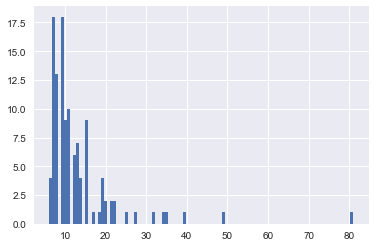

In [1780]:
plt.hist([len(revisedClusters[key]) for key in revisedClusters.keys()],bins=100)

## Infer coregulated modules (only supported for Homo Sapiens)

In [1781]:
reload(miner)
t1 = time.time()
# get first principal component axes of clusters
axes = miner.principalDf(revisedClusters,expressionData,subkey=None,minNumberGenes=1)
# analyze revised clusters for enrichment in relational database (default: transcription factor binding site database)
mechanisticOutput = miner.mechanisticInference(axes,revisedClusters,expressionData,correlationThreshold=minCorrelation,dataFolder=os.path.join("..","data"))
# write mechanistic output to .json file
miner.write_json(mechanisticOutput,os.path.join(resultsDirectory,"mechanisticOutput.json"))
# order mechanisticOutput as {tf:{coexpressionModule:genes}} 
coregulationModules = miner.getCoregulationModules(mechanisticOutput)
# write coregulation modules to .json file
miner.write_json(coregulationModules,os.path.join(resultsDirectory,"coregulationModules.json"))
# get final regulons by keeping genes that requently appear coexpressed and associated to a common regulator
regulons = miner.getRegulons(coregulationModules,minNumberGenes=minNumberRegulonGenes,freqThreshold = 0.333)
# write regulons to json file
miner.write_json(regulons,os.path.join(resultsDirectory,"regulons.json"))
# define coexpression modules as composite of coexpressed regulons
coexpressionModules = miner.getCoexpressionModules(mechanisticOutput)
# write coexpression modules to .json file
miner.write_json(coexpressionModules,os.path.join(resultsDirectory,"coexpressionModules.json"))

t2 = time.time()
print("completed mechanistic inference in {:.2f} minutes".format((t2-t1)/60.))

0
1
2
26
23
3
24
25
4
5
49
27
28
6
29
46
7
30
47
31
48
8
32
9
33
50
51
34
10
52
35
11
53
36
70
54
37
12
71
55
38
72
56
13
39
73
57
40
74
14
58
75
41
59
15
76
42
60
77
16
43
61
78
79
62
94
17
44
63
80
95
45
81
18
96
64
82
97
65
19
83
98
66
84
99
20
67
85
100
21
86
68
101
22
87
69
102
88
103
89
104
90
105
106
91
107
92
108
93
109
110
111
112
113
114
115
116
117
completed mechanistic inference in 0.39 minutes


In [1782]:
reload(miner)
#reconvert revised clusters to original gene annotations
annotatedRevisedClusters = miner.convertDictionary(revisedClusters,conversionTable)
# write annotated coexpression clusters to .json file
miner.write_json(revisedClusters,os.path.join(resultsDirectory,"coexpressionDictionary_annotated.json"))


In [1783]:
reload(miner)

f1Regulons = miner.f1Regulons(coregulationModules,minNumberGenes=5,freqThreshold = 0.1)

In [1784]:
regulonModules, regulonDf = miner.regulonDictionary(regulons)
print(len(regulonModules))

117


In [1785]:
reload(miner)
#reconvert results into original annotations
regulonAnnotatedDf = miner.convertRegulons(regulonDf,conversionTable)
regulonAnnotatedDf.to_csv(os.path.join(resultsDirectory,"regulons_annotated.csv"))
#reconvert regulons
annotatedRegulons = miner.convertDictionary(regulonModules,conversionTable)
# write annotated regulons to .json file
miner.write_json(regulons,os.path.join(resultsDirectory,"regulons_annotated.json"))
#reconvert coexpression modules
annotatedCoexpressionModules = miner.convertDictionary(coexpressionModules,conversionTable)
# write annotated coexpression modules to .json file
miner.write_json(coexpressionModules,os.path.join(resultsDirectory,"coexpressionModules_annotated.json"))

In [1786]:
print(len(regulonDf.Regulator.unique()),len(regulonDf.Gene.unique()))

(45, 513)


## Infer bicluster membership (start here if you only have revisedClusters)

In [1787]:
# select reference dictionary for downstream analysis (revisedClusters, coexpressionModules, or regulonModules)
referenceDictionary = regulonModules
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2)
# for each cluster, give samples that show low coherent cluster activity
underExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0)
# for each cluster, give samples that do not show coherent cluster activity
#dysregulatedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="excluded")
# for each cluster, give samples that show coherent cluster activity, despite magnitude of expression
#coherentMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="included")

done!
done!


## Generate bicluster membership incidence matrices

In [1788]:
# write membership matrices to .csv file
overExpressedMembersMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)
overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"))
underExpressedMembersMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)
underExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"))
# dysregulatedMembersMatrix = miner.membershipToIncidence(dysregulatedMembers,expressionData)
# dysregulatedMembersMatrix.to_csv(os.path.join(resultsDirectory,"dysregulatedMembers.csv"))
# coherentMembersMatrix = miner.membershipToIncidence(coherentMembers,expressionData)
# coherentMembersMatrix.to_csv(os.path.join(resultsDirectory,"coherentMembers.csv"))

## Cluster samples into subtypes

In [1789]:
# choose membership type for sample class prediction
sampleDictionary = overExpressedMembers
sampleMatrix = overExpressedMembersMatrix

In [1790]:
similarityClusters = miner.f1Decomposition(sampleDictionary,thresholdSFM=0.1)
initialClasses = [i for i in similarityClusters if len(i)>4]

done!


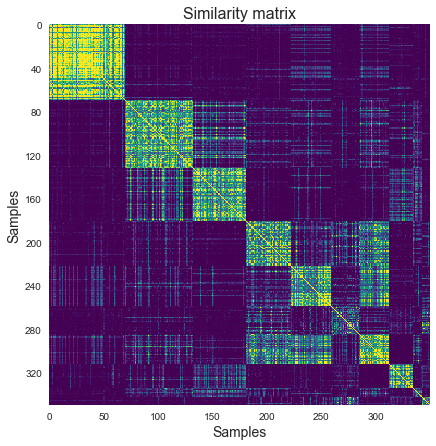

In [1791]:
sampleFrequencyMatrix = miner.sampleCoincidenceMatrix(sampleDictionary,freqThreshold = 0.333,frequencies=True) #0.333
similarityMatrix = sampleFrequencyMatrix*sampleFrequencyMatrix.T
miner.plotSimilarity(similarityMatrix,np.hstack(initialClasses),vmin=0,vmax=0.5,title="Similarity matrix",xlabel="Samples",ylabel="Samples",fontsize=14,figsize=(7,7),savefig=os.path.join(resultsDirectory,"similarityMatrix_regulons.pdf"))

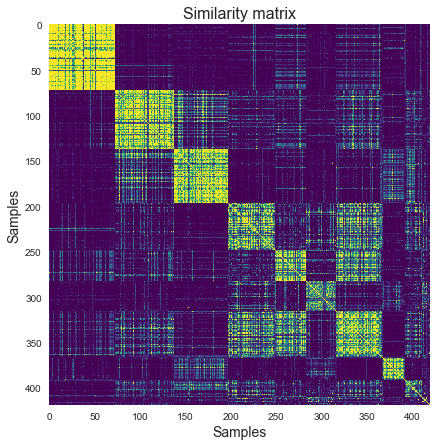

In [1792]:
centroidClusters, centroidMatrix = miner.centroids(initialClasses,sampleMatrix,f1Threshold = 0.1,returnCentroids=True) #0.3
centroidMatrix.to_csv(os.path.join(resultsDirectory,"centroids.csv"))
unmapped = list(sampleMatrix.columns[np.where(sampleMatrix.sum(axis=0)==0)[0]])
mappedSamples = [i for i in np.hstack(centroidClusters) if i not in unmapped]
miner.plotSimilarity(similarityMatrix,mappedSamples,vmin=0,vmax=0.333,title="Similarity matrix",xlabel="Samples",ylabel="Samples",fontsize=14,figsize=(7,7),savefig=os.path.join(resultsDirectory,"centroidClusters_regulons.pdf"))

In [1793]:
mappedClusters = miner.mapExpressionToNetwork(centroidMatrix,sampleMatrix,threshold = 0.05)

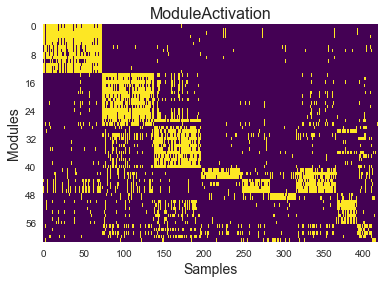

In [1794]:
reload(miner)
orderedOverExpressedMembers = miner.orderMembership(centroidMatrix,sampleMatrix,mappedClusters,ylabel="Modules",resultsDirectory=None)

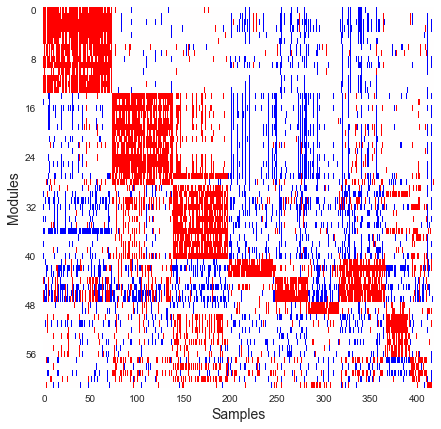

In [1795]:
reload(miner)
orderedDM = miner.plotDifferentialMatrix(overExpressedMembersMatrix,underExpressedMembersMatrix,orderedOverExpressedMembers,cmap="bwr",aspect="auto",saveFile=os.path.join(resultsDirectory,"centroid_clusters_heatmap.pdf"))

11
2
2
2
2
2
2
2
2
2
2
3
2


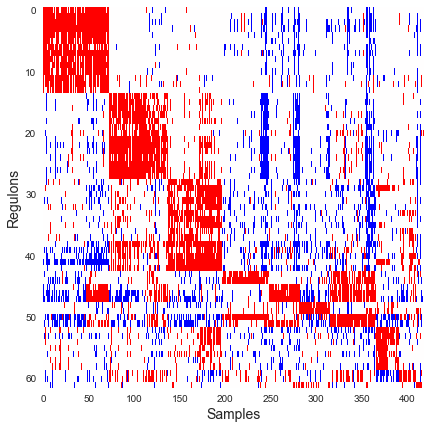

In [1796]:
reload(miner)
difference_complete = overExpressedMembersMatrix-underExpressedMembersMatrix
programs, states = miner.mosaic(dfr=orderedDM,clusterList=centroidClusters,minClusterSize_x=5,minClusterSize_y=5,allow_singletons=False,max_groups=50,saveFile=os.path.join(resultsDirectory,"mosiac_heatmap.pdf"),random_state=12)   
transcriptional_programs, program_regulons = miner.transcriptionalPrograms(programs,referenceDictionary)

In [1797]:
print(len(states))
print(len(transcriptional_programs))

21
13


In [1802]:
groups = [states[i] for i in range(len(states)) if len(states[i])>=int(np.ceil(0.01*expressionData.shape[1]))]
program_list = [program_regulons[("").join(["TP",str(i)])] for i in range(len(program_regulons))]
print(len(groups),len(np.hstack(groups)))
print('sample coverage within sufficiently large states: {:.1f}%'.format(100*float(len(np.hstack(groups)))/expressionData.shape[1]))

(20, 416)
sample coverage within sufficiently large states: 99.3%


In [1799]:
#write all transcriptional program genesets to text files for external analysis
if not os.path.isdir(os.path.join(resultsDirectory,"transcriptional_programs_coexpressionModules")):
    os.mkdir(os.path.join(resultsDirectory,"transcriptional_programs_coexpressionModules"))
    
for tp in transcriptional_programs.keys():
    np.savetxt(os.path.join(resultsDirectory,"transcriptional_programs_coexpressionModules",(".").join([tp,"txt"])),transcriptional_programs[tp],fmt="%1.50s")

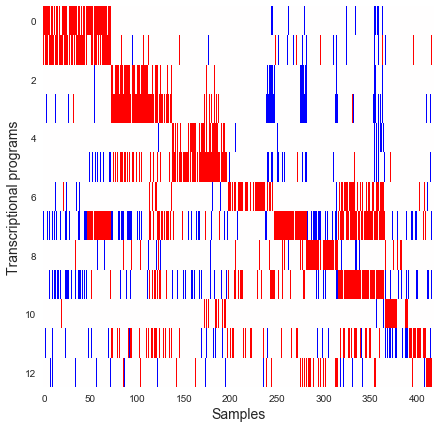

In [1800]:
reload(miner)
statesDf = miner.stateProjection(df=orderedDM,programs=program_list,states=states,stateThreshold=0.65,saveFile=os.path.join(resultsDirectory,"transcriptional_programs_vs_samples.pdf"))

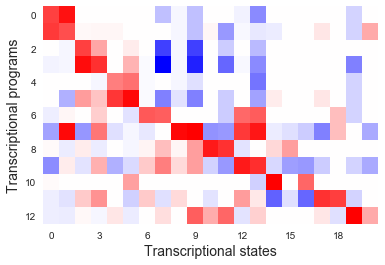

In [1801]:
reload(miner)
programsVsStates = miner.programsVsStates(statesDf,states,filename=os.path.join(resultsDirectory,"programs_vs_states.pdf"))

# Visualize with tSNE

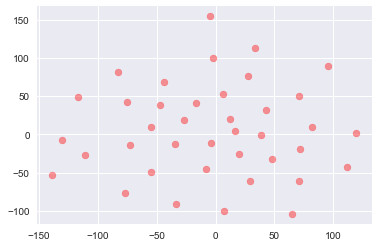

In [1596]:
# tSNE applied to expressionData. Set plotOnly = False to return tSNE coordinates
# consider changing the perplexity to explore different degrees of cluster separation
miner.tsne(expressionData,perplexity=15,n_components=2,n_iter=1000,plotOnly=True,plotColor="red",alpha=0.4)

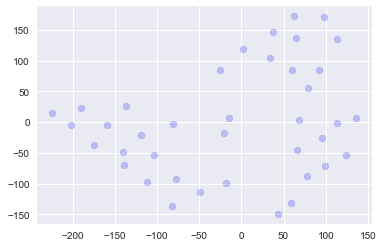

In [1607]:
# tSNE applied to df_for_tsne. Consider changing the perplexity in the range of 5 to 50
df_for_tsne = orderedDM.copy()
X_embedded = miner.tsne(df_for_tsne,perplexity=12,n_components=2,n_iter=1000,plotOnly=None,plotColor="blue",alpha=0.2)
tsneDf = pd.DataFrame(X_embedded)
tsneDf.index = df_for_tsne.columns
tsneDf.columns = ["tsne1","tsne2"]
#plt.savefig(os.path.join(resultsDirectory,"tsne_metaregulons_o3.pdf"),bbox_inches="tight")

In [1525]:
# visualize distribution of target expression across transcriptional states
nsd2, maf, ccnd1, csk1b, ikzf1, ikzf3, tp53, e2f1, ets1, phf19 = ["ENSG00000109685","ENSG00000178573","ENSG00000110092","ENSG00000173207","ENSG00000185811","ENSG00000161405","ENSG00000141510","ENSG00000101412","ENSG00000134954","ENSG00000119403"]
target = tp53
target_expression = np.array(expressionData.loc[target,tsneDf.index])

# overlay target expression
plt.scatter(tsneDf.iloc[:,0],tsneDf.iloc[:,1],cmap="bwr",c=target_expression,alpha=0.65)
plt.savefig(os.path.join(resultsDirectory,("").join(["labeled_tsne_",target,"_overlay_o2.pdf"])),bbox_inches="tight")

KeyError: 'the label [ENSG00000141510] is not in the [index]'

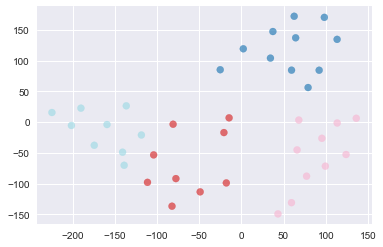

In [1613]:
# define subtypes by clustering tsne plot

# How many clusters do you expect? Start with number of states
numberOfClusters = 4

# Are the clusters separated how you thought? If not, change the random_state to a different number and retry
random_state=1

clusters, labels, centroids = miner.kmeans(tsneDf,numClusters=numberOfClusters,random_state=random_state)

# overlay cluster labels
plt.scatter(tsneDf.iloc[:,0],tsneDf.iloc[:,1],cmap="tab20",c=labels,alpha=0.65)
plt.savefig(os.path.join(resultsDirectory,"labeled_tsne_kmeans.pdf"),bbox_inches="tight")

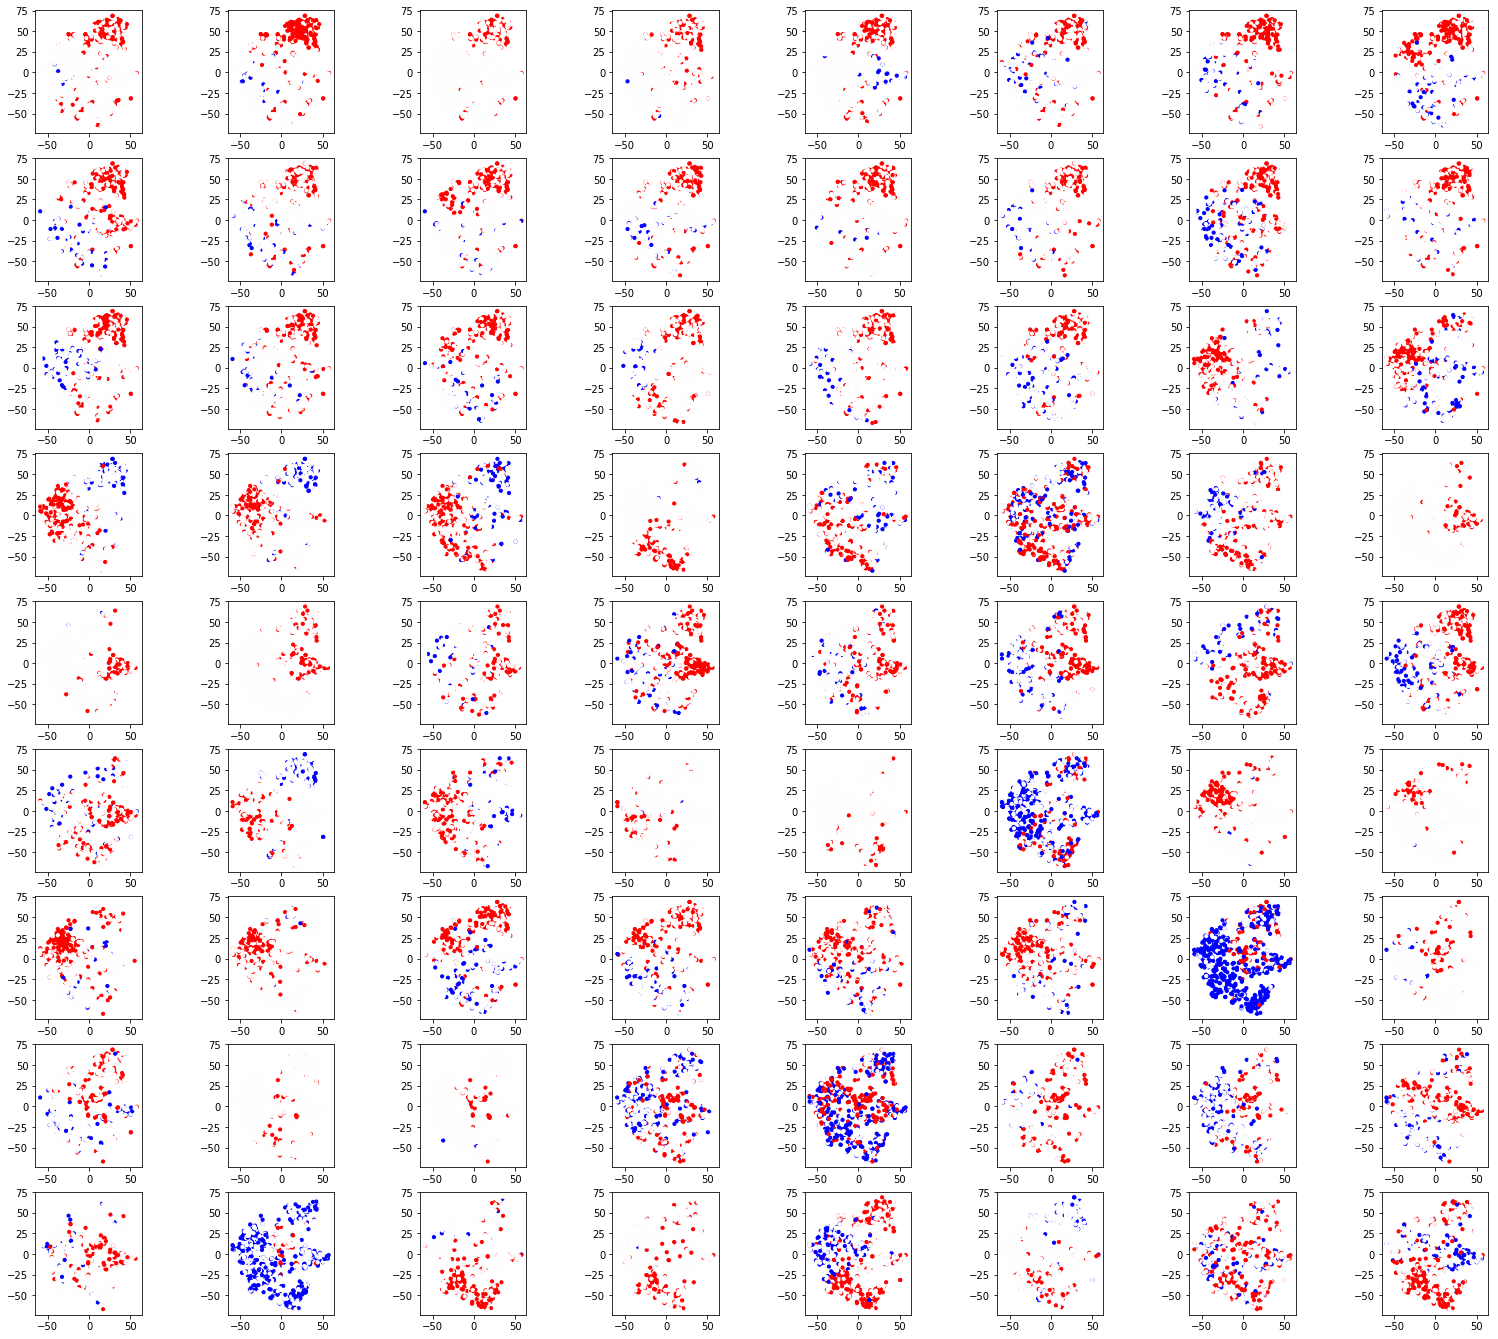

In [86]:
#plot all states onto single stitched output
reload(miner)
miner.plotStates(statesDf,tsneDf,numCols=8,numRows=9,saveFile = os.path.join(resultsDirectory,"states_regulons_o2_tsne.pdf"),size=10,aspect=1,scale=3)

# Functional enrichment analysis

In [1803]:
#This simple enrichment analysis performs hypergeometric tests against reference databases
#The transcriptional_programs genesets saved in the resultsDirectory can be input into more... 
#sophisticated enrichment analysis tools

reload(miner)
pathways_enrichment = miner.enrichmentAnalysis(dict_=transcriptional_programs,reference_dict="pathways.pkl",reciprocal_dict="pathways_reciprocal.pkl",genes_with_expression=expressionData.index,resultsDirectory=resultsDirectory,numCores=5,min_overlap = 3,threshold = 0.01)

initializing enrichment analysis
completed enrichment analysis in 3.44 seconds


In [1804]:
pathways_enrichment

{'TP0': {},
 'TP10': {},
 'TP2': {},
 'TP3': {},
 'TP4': {},
 'TP5': {},
 'TP6': {},
 'TP7': {'BIOCARTA_MCM_PATHWAY': 8.018018114330369e-07,
  'KEGG_CELL_CYCLE': 0.009223679852764047,
  'KEGG_DNA_REPLICATION': 0.0012367179314542794,
  'REACTOME_ACTIVATION_OF_ATR_IN_RESPONSE_TO_REPLICATION_STRESS': 1.4009739515696388e-05,
  'REACTOME_ACTIVATION_OF_THE_PRE_REPLICATIVE_COMPLEX': 3.131694364558023e-06,
  'REACTOME_ASSEMBLY_OF_THE_PRE_REPLICATIVE_COMPLEX': 0.0011347004333932932,
  'REACTOME_ASSOCIATION_OF_LICENSING_FACTORS_WITH_THE_PRE_REPLICATIVE_COMPLEX': 0.000984673870760393,
  'REACTOME_CDC6_ASSOCIATION_WITH_THE_ORC_ORIGIN_COMPLEX': 0.007006890481082765,
  'REACTOME_DNA_REPLICATION': 0.0005605919027063872,
  'REACTOME_DNA_STRAND_ELONGATION': 2.0972329277713034e-07,
  'REACTOME_E2F_MEDIATED_REGULATION_OF_DNA_REPLICATION': 1.1162950181741145e-05,
  'REACTOME_G1_S_SPECIFIC_TRANSCRIPTION': 5.021291600185912e-07,
  'REACTOME_G1_S_TRANSITION': 0.00012167875789492859,
  'REACTOME_G2_M_CHECKPOI

In [436]:
state_ix = 8
exp_thresh = 0.4

overEx = [("").join(["TP",str(i)]) for i in np.where(pixel.iloc[:,state_ix]>=exp_thresh)[0]]
overexpressed_state_keys = list(set(overEx)&set(pathways_enrichment.keys()))

underEx = [("").join(["TP",str(i)]) for i in np.where(pixel.iloc[:,state_ix]<=-exp_thresh)[0]]
underexpressed_state_keys = list(set(underEx)&set(pathways_enrichment.keys()))

print(len(overexpressed_state_keys),len(underexpressed_state_keys))
overexpressed_state_keys

(13, 4)


['TP60',
 'TP40',
 'TP59',
 'TP14',
 'TP31',
 'TP33',
 'TP32',
 'TP35',
 'TP34',
 'TP37',
 'TP36',
 'TP39',
 'TP38']

In [327]:
overExFunctions = np.hstack([pathways_enrichment[key].keys() for key in overexpressed_state_keys])
count_overFunctions = Counter(overExFunctions)
rank_overFunctions = count_overFunctions.most_common()
rank_overFunctions

[('REACTOME_REGULATION_OF_INSULIN_LIKE_GROWTH_FACTOR_IGF_ACTIVITY_BY_INSULIN_LIKE_GROWTH_FACTOR_BINDING_PROTEINS_IGFBPS',
  2),
 ('PID_INTEGRIN1_PATHWAY', 2),
 ('KEGG_LEUKOCYTE_TRANSENDOTHELIAL_MIGRATION', 1),
 ('BIOCARTA_INTEGRIN_PATHWAY', 1),
 ('REACTOME_SIGNALING_BY_NOTCH3', 1),
 ('REACTOME_REGULATION_OF_WATER_BALANCE_BY_RENAL_AQUAPORINS', 1),
 ('REACTOME_CELL_EXTRACELLULAR_MATRIX_INTERACTIONS', 1),
 ('PID_INTEGRIN2_PATHWAY', 1),
 ('PID_BMP_PATHWAY', 1),
 ('KEGG_ARGININE_AND_PROLINE_METABOLISM', 1),
 ('REACTOME_AQUAPORIN_MEDIATED_TRANSPORT', 1),
 ('REACTOME_CELL_JUNCTION_ORGANIZATION', 1),
 ('BIOCARTA_CXCR4_PATHWAY', 1),
 ('REACTOME_CELL_SURFACE_INTERACTIONS_AT_THE_VASCULAR_WALL', 1),
 ('PID_IL8_CXCR2_PATHWAY', 1),
 ('REACTOME_CS_DS_DEGRADATION', 1),
 ('PID_EPHB_FWD_PATHWAY', 1),
 ('REACTOME_HDL_MEDIATED_LIPID_TRANSPORT', 1),
 ('REACTOME_BIOSYNTHESIS_OF_THE_N_GLYCAN_PRECURSOR_DOLICHOL_LIPID_LINKED_OLIGOSACCHARIDE_LLO_AND_TRANSFER_TO_A_NASCENT_PROTEIN',
  1),
 ('BIOCARTA_MET_PATHWAY'

In [325]:
underExFunctions = np.hstack([pathways_enrichment[key].keys() for key in underexpressed_state_keys])
count_underFunctions = Counter(underExFunctions)
rank_underFunctions = count_underFunctions.most_common()
rank_underFunctions

ValueError: need at least one array to concatenate

# Survival analysis

In [1306]:
# load survival data
survivalMMRF = pd.read_csv(os.path.join("..","data","survivalIA12.csv"),index_col=0,header=0)
survivalDfMMRF = survivalMMRF.iloc[:,0:2]
survivalDfMMRF.columns = ["duration","observed"]
overExpressedMembersMatrixMMRF = overExpressedMembersMatrix
overExpressedMembersMatrixMMRF = overExpressedMembersMatrixMMRF.loc[orderedOverExpressedMembers.index,:]

In [1307]:
#generate Kaplan-Meier estimates
kmDf = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfMMRF = miner.guanRank(kmSurvival=kmDf)

22


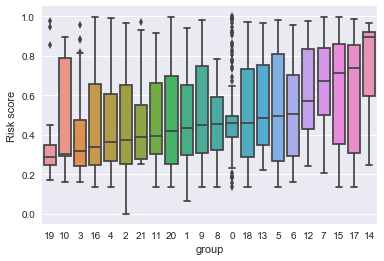

In [1750]:
srv = guanSurvivalDfMMRF.copy()
guan_srv = pd.DataFrame(srv.loc[:,"GuanScore"])
guan_srv.columns = ["value"]
guan_srv_group = pd.DataFrame(np.zeros(guan_srv.shape[0]))
guan_srv_group.index = guan_srv.index
guan_srv_group.columns = ["group"]
guan_srv_df = pd.concat([guan_srv,guan_srv_group],axis=1)

mmrf_groups = [i for i in states if len(i)>=int(np.ceil(0.01*expressionData.shape[1]))]
#groups.sort(key = lambda s: -len(s))
labels = range(len(mmrf_groups))
medians = []
for i in range(len(mmrf_groups)):
    group = list(set(srv.index)&set(mmrf_groups[i]))
    if len(group)>=1:
        medians.append(np.median(guan_srv_df.loc[group,"value"]))
    elif len(group)<1:
        medians.append(0)
    label = labels[i]
    guan_srv_df.loc[group,"group"] = label
print(len(medians))
    
import seaborn as sns
survival_tag = "MMRF_risk_groups"
sns.boxplot(x='group', y='value', data=guan_srv_df,order=np.argsort(medians))
plt.ylabel("Risk score")
boxplotFilename = ("_").join([survival_tag,"boxplot.pdf"])
plt.savefig(os.path.join(resultsDirectory,boxplotFilename),bbox_inches="tight")

In [1751]:
srv = survivalDfMMRF.copy()
cox_programs = miner.parallelMemberSurvivalAnalysis(membershipDf = statesDf,numCores=5,survivalPath="",survivalData=srv)

cox_hr = [cox_programs[i][0] for i in range(len(cox_programs))]
cox_p = [cox_programs[i][1] for i in range(len(cox_programs))]
cox_df = pd.DataFrame(np.vstack([cox_hr,cox_p]).T)
cox_df.index = [cox_programs.keys()[i] for i in range(len(cox_programs))]
cox_df.columns = ["HR","p-value"]
cox_df.sort_values(by="HR",ascending=False,inplace=True)
cox_df

10
10
10
10
10


HR       p-value
44  7.248976  4.199328e-13
43  4.702701  2.567424e-06
53  4.237988  2.255319e-05
28  3.423322  6.186071e-04
35  2.905724  3.664044e-03
29  2.604460  9.201904e-03
13  2.583730  9.773823e-03
47  1.809543  7.036663e-02
27  1.792303  7.308444e-02
25  1.704180  8.834751e-02
33  1.554920  1.199652e-01
46  1.550343  1.210591e-01
32  1.516343  1.294325e-01
42  1.400006  1.615116e-01
37  1.100477  2.711245e-01
52  1.090624  2.754385e-01
49  0.809656  4.181381e-01
59  0.808967  4.185343e-01
16  0.698874  4.846305e-01
41  0.685784  4.928492e-01
11  0.649771  5.158403e-01
18  0.638438  5.231885e-01
7   0.615231  5.384022e-01
12  0.299494  7.645631e-01
40  0.174565  8.614217e-01
3   0.027031  9.784352e-01
31  0.021680  9.827031e-01
23 -0.024512  9.804443e-01
26 -0.029909  9.761395e-01
2  -0.226822  8.205625e-01
17 -0.252460  8.006858e-01
45 -0.262703  7.927794e-01
30 -0.305995  7.596086e-01
6  -0.388683  6.975107e-01
36 -0.479640  6.314835e-01
34 -0.557418  5.772417e-01
38 -0.562698  5.736403e-01
4  -0.584388  5.589590e-01
57 -0.586725  5.573883e-01
21 -0.790800  4.290609e-01
10 -0.791275  4.287834e-01
55 -0.933888  3.503616e-01
9  -0.956491  3.388242e-01
39 -0.980090  3.270417e-01
48 -1.001663  3.165063e-01
1  -1.050701  2.933961e-01
58 -1.138969  2.547162e-01
50 -1.366279  1.718513e-01
0  -1.398113  1.620790e-01
14 -1.415994  1.567772e-01
15 -1.435987  1.510061e-01
54 -1.525374  1.271659e-01
22 -1.595770  1.105401e-01
5  -1.724160  8.467900e-02
24 -1.835065  6.649599e-02
56 -2.373984  1.759733e-02
20 -2.754236  5.882933e-03
19 -2.960157  3.074826e-03
8  -3.057711  2.230343e-03
51 -3.444123  5.729145e-04

In [1654]:
hrs = []
for key in cox_programs.keys():
    HR = cox_programs[key][0]
    hrs.append(HR)
    
print(max(hrs))

8.09856915831453


In [1752]:
srv = survivalDfMMRF.copy()

state_members = [states[i] for i in range(len(states)) if len(states[i])>=9]
sufficient_states = [i for i in range(len(states)) if len(states[i])>=9]
state_survival = pd.DataFrame(np.zeros((len(state_members),srv.shape[0])))
state_survival.index = sufficient_states
state_survival.columns = srv.index
for ix in range(len(sufficient_states)):
    sm = list(set(state_members[ix])&set(srv.index))
    state_survival.loc[sufficient_states[ix],sm] = 1
    
cox_states = miner.parallelMemberSurvivalAnalysis(membershipDf = state_survival,numCores=5,survivalPath="",survivalData=srv)

cox_hr = [cox_states[i][0] for i in cox_states.keys()]
cox_p = [cox_states[i][1] for i in cox_states.keys()]
cox_df = pd.DataFrame(np.vstack([cox_hr,cox_p]).T)
cox_df.index = cox_states.keys()
cox_df.columns = ["HR","p-value"]
cox_df.sort_values(by="HR",ascending=False,inplace=True)
cox_df

HR   p-value
15  4.201548  0.000027
7   4.088725  0.000043
13  2.187170  0.028730
16  1.836283  0.066316
18  1.403569  0.160447
14  1.307474  0.191052
5   1.086563  0.277230
9   0.528478  0.597168
6   0.461419  0.644498
19  0.274930  0.783370
8  -0.165389  0.868638
24 -0.236531  0.813021
12 -0.261937  0.793370
10 -0.385246  0.700055
25 -0.609180  0.542405
0  -0.653039  0.513731
1  -0.788515  0.430396
2  -1.039629  0.298512
4  -1.107144  0.268232
17 -1.261842  0.207006
20 -2.172735  0.029800
3  -2.566001  0.010288

In [1753]:
for i in range(len(states)):
    print(i,len(states[i]))

(0, 125)
(1, 104)
(2, 58)
(3, 53)
(4, 45)
(5, 38)
(6, 39)
(7, 36)
(8, 10)
(9, 36)
(10, 10)
(11, 2)
(12, 32)
(13, 30)
(14, 30)
(15, 28)
(16, 19)
(17, 32)
(18, 16)
(19, 28)
(20, 24)
(21, 7)
(22, 4)
(23, 2)
(24, 44)
(25, 20)
(26, 4)
(27, 5)


# Mutation analysis

In [896]:
mutations = pd.read_csv(os.path.join(resultsDirectory,"..","data","filteredMutationsIA12.csv"),index_col=0,header=0)
translocations = pd.read_csv(os.path.join(resultsDirectory,"..","data","translocationsIA12.csv"),index_col=0,header=0)

In [ ]:
##per patient visit


#D_TRI_CF_ABNORMAILITYP - chr17tp53
#D_TRI_CF_ABNORMALITYPR - del13
#D_TRI_CF_ABNORMALITYPR2 - del17
#D_TRI_CF_ABNORMALITYPR3 - t414
#D_TRI_CF_ABNORMALITYPR4 - t614
#D_TRI_CF_ABNORMALITYPR5 - t814
#D_TRI_CF_ABNORMALITYPR6 - t1114
#D_TRI_CF_ABNORMALITYPR7 - t1214
#D_TRI_CF_ABNORMALITYPR8 - t1416
#D_TRI_CF_ABNORMALITYPR11 - del17p
#D_TRI_CF_ABNORMALITYPR12 - del1p
#D_TRI_CF_ABNORMALITYPR13 - amp1q




Index([u'RNASeq_CCND1_Call', u'RNASeq_CCND2_Call', u'RNASeq_CCND3_Call',
       u'RNASeq_FGFR3_Call', u'RNASeq_MAFA_Call', u'RNASeq_MAFB_Call',
       u'RNASeq_MAF_Call', u'RNASeq_MYC_Call', u'RNASeq_WHSC1_Call'],
      dtype='object')


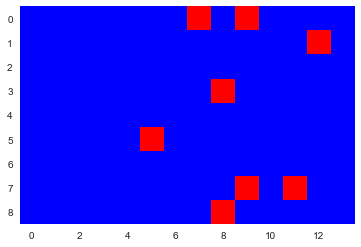

In [941]:
plt.imshow(translocations.loc[:,mmrf_groups[13]],cmap="bwr",aspect="auto")
plt.grid(False)
print(translocations.index)

In [966]:
ccnd1_samples = translocations.columns[translocations.iloc[0,:]==1]
whsc1_samples = translocations.columns[translocations.iloc[-1,:]==1]

t414 = {}
for i in range(len(states)):
    tmp = list(set(states[i])&set(whsc1_samples)&set(guanSurvivalDfMMRF.index))
    if len(tmp)>=5:
        t414[i]=tmp
        print(i,len(tmp))
print(t414.keys())

t1114 = {}
for i in range(len(states)):
    tmp = list(set(states[i])&set(ccnd1_samples)&set(guanSurvivalDfMMRF.index))
    if len(tmp)>=5:
        t1114[i]=tmp
        print(i,len(tmp))
print(t1114.keys())
    
t414_0 = list(set(states[0])&set(whsc1_samples)&set(guanSurvivalDfMMRF.index))
t414_1 = list(set(states[1])&set(whsc1_samples)&set(guanSurvivalDfMMRF.index))
t414_6 = list(set(states[6])&set(whsc1_samples)&set(guanSurvivalDfMMRF.index))
t414_7 = list(set(states[7])&set(whsc1_samples)&set(guanSurvivalDfMMRF.index))
t414_27 = list(set(states[27])&set(whsc1_samples)&set(guanSurvivalDfMMRF.index))

t414_22 = list(set(states[22])&set(whsc1_samples)&set(guanSurvivalDfMMRF.index))

t1114_0 = list(set(states[0])&set(ccnd1_samples)&set(guanSurvivalDfMMRF.index))
t1114_1 = list(set(states[1])&set(ccnd1_samples)&set(guanSurvivalDfMMRF.index))
t1114_4 = list(set(states[4])&set(ccnd1_samples)&set(guanSurvivalDfMMRF.index))
t1114_5 = list(set(states[5])&set(ccnd1_samples)&set(guanSurvivalDfMMRF.index))
t1114_19 = list(set(states[19])&set(ccnd1_samples)&set(guanSurvivalDfMMRF.index))
t1114_25 = list(set(states[25])&set(ccnd1_samples)&set(guanSurvivalDfMMRF.index))

t1114_9 = list(set(states[9])&set(ccnd1_samples)&set(guanSurvivalDfMMRF.index))
t1114_2 = list(set(states[2])&set(ccnd1_samples)&set(guanSurvivalDfMMRF.index))
t1114_4 = list(set(states[4])&set(ccnd1_samples)&set(guanSurvivalDfMMRF.index))

guanSurvivalDfMMRF.loc[list(set(whsc1_samples)&set(guanSurvivalDfMMRF.index))]

t414_all = list(set(whsc1_samples)&set(guanSurvivalDfMMRF.index))
#print(len(t414_0),len(t414_5))

(0, 22)
(1, 8)
(6, 42)
(7, 18)
(27, 6)
[0, 1, 27, 6, 7]
(0, 40)
(1, 7)
(4, 42)
(5, 43)
(19, 5)
(25, 6)
[0, 1, 4, 5, 19, 25]


In [971]:
median_gs = np.median(guanSurvivalDfMMRF.loc[:,"GuanScore"])
print(median_gs)

hr_whsc1 = np.where(guanSurvivalDfMMRF.loc[t414_all,"GuanScore"]>median_gs)[0]
print(len(hr_whsc1))
print(len(hr_whsc1)/float(len(t414_all)))


0.44962355760334705
67
0.638095238095


5


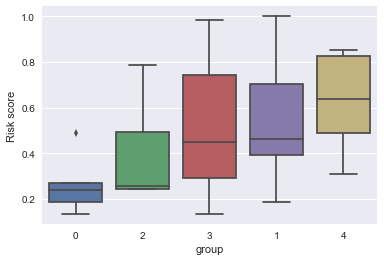

In [978]:
srv = guanSurvivalDfMMRF.copy()
guan_srv = pd.DataFrame(srv.loc[:,"GuanScore"])
guan_srv.columns = ["value"]
guan_srv_group = pd.DataFrame(np.zeros(guan_srv.shape[0]))
guan_srv_group.index = guan_srv.index
guan_srv_group.columns = ["group"]
guan_srv_df = pd.concat([guan_srv,guan_srv_group],axis=1)

    
groups = [np.hstack([t414_0,t414_1]),t414_7]
groups = [t1114_19,t1114_0,t1114_1,t1114_5,t1114_25]
labels = range(len(groups)) #[0,1,5,11,12,21]  

pooled_groups = list(set(np.hstack(groups))&set(guan_srv_df.index))
guan_srv_df = guan_srv_df.loc[pooled_groups,:]
medians = []
for i in range(len(groups)):
    group = list(set(groups[i])&set(guan_srv_df.index))
    if len(group)>=1:
        medians.append(np.median(guan_srv_df.loc[group,"value"]))
    elif len(group)<1:
        medians.append(0)
    label = labels[i]
    guan_srv_df.loc[group,"group"] = label
print(len(medians))
    
import seaborn as sns
survival_tag = "MMRF_t(11;14)"
sns.boxplot(x='group', y='value', data=guan_srv_df,order=np.argsort(medians))
plt.ylabel("Risk score")
boxplotFilename = ("_").join([survival_tag,"boxplot.pdf"])
plt.savefig(os.path.join(resultsDirectory,boxplotFilename),bbox_inches="tight")

In [434]:
regs = []
for reg_id in program_regulons["TP54"]:
    tmp = regulonDf[regulonDf.Regulon_ID==reg_id]["Regulator"].unique()[0]
    regs.append(tmp)

miner.gene_conversion(gene_list=regs,input_type="ensembl.gene",output_type="symbol",list_symbols=True)

querying 1-45...done.
Finished.


[u'LEF1',
 u'MIXL1',
 u'SOX9',
 u'THRA',
 u'POU2F1',
 u'ARID5A',
 u'BRCA1',
 u'EBF1',
 u'THRB',
 u'CEBPA',
 u'DDIT3',
 u'NFKB1',
 u'RARA',
 u'HOXA10',
 u'STAT5B',
 u'POLR3A',
 u'TRAF4',
 u'IRX3',
 u'GATA3',
 u'SOX30',
 u'TAL1',
 u'NKX3-1',
 u'TP53',
 u'ZNF740',
 u'HNF1A',
 u'SPI1',
 u'TCF7',
 u'IRF8',
 u'ZNF410',
 u'NFE2',
 u'SPDEF',
 u'HLTF',
 u'HESX1',
 u'BCL6',
 u'NFIL3',
 u'HLX',
 u'LTF',
 u'ZBTB16',
 u'FOSL1',
 u'PRRX1',
 u'HOMEZ',
 u'GATA1',
 u'PPARG',
 u'STAT5A',
 u'HOXA9']

In [489]:
path_FISH = os.path.join(os.path.split(os.getcwd())[0],"data","MMRF_CoMMpass_IA12a_CNA_Exome_FISH_CN_All_Specimens.txt")
FISH = pd.read_table(path_FISH,index_col=0,header=0)
FISH.columns[-92:-74]

Index([u'SeqExome_Cp_BIRCs_20percent', u'SeqExome_Cp_BIRCs_50percent',
       u'SeqExome_Cp_CDKN2C_20percent', u'SeqExome_Cp_CDKN2C_50percent',
       u'SeqExome_Cp_CYLD_20percent', u'SeqExome_Cp_CYLD_50percent',
       u'SeqExome_Cp_FAM46C_20percent', u'SeqExome_Cp_FAM46C_50percent',
       u'SeqExome_Cp_RB1_20percent', u'SeqExome_Cp_RB1_50percent',
       u'SeqExome_Cp_TP53_20percent', u'SeqExome_Cp_TP53_50percent',
       u'SeqExome_Cp_TRAF2_20percent', u'SeqExome_Cp_TRAF2_50percent',
       u'SeqExome_Cp_TRAF3_20percent', u'SeqExome_Cp_TRAF3_50percent',
       u'SeqExome_Cp_UTX_20percent', u'SeqExome_Cp_UTX_50percent'],
      dtype='object')

In [502]:
amp1q_call = "SeqExome_Cp_1q21_20percent"
del1p_call = "SeqExome_Cp_1p22_20percent"
del13q14_call = "SeqExome_Cp_13q14_20percent"
del17p13_call = "SeqExome_Cp_17p13_20percent"
hyperdiploid_call = 'SeqExome_Cp_Hyperdiploid_Call'
hyperdiploid_chr = 'SeqExome_Cp_Hyperdiploid_Chr_Count'

myc_call = "SeqExome_Cp_MYC_20percent"
BIRCs = "SeqExome_Cp_BIRCs_20percent"
CDKN2C = "SeqExome_Cp_CDKN2C_20percent"
CYLD = "SeqExome_Cp_CYLD_20percent"
FAM46C = "SeqExome_Cp_FAM46C_20percent"
RB1 = "SeqExome_Cp_RB1_20percent"
TP53 = "SeqExome_Cp_TP53_20percent"
TRAF2 = "SeqExome_Cp_TRAF2_20percent"
TRAF3 = "SeqExome_Cp_TRAF3_20percent"
UTX = "SeqExome_Cp_UTX_20percent"

fishlist = [
    amp1q_call,
    del1p_call,
    del13q14_call,
    del17p13_call,
    hyperdiploid_call,
    myc_call,
    BIRCs,
    CDKN2C,
    CYLD,
    FAM46C,
    RB1,
    TP53,
    TRAF2,
    TRAF3,
    UTX
]

calls_cols = [
    "amp1q",
    "del1p",
    "del13q14",
    "del17p13",
    "hyperdiploid",
    "myc",
    "BIRCs",
    "CDKN2C",
    "CYLD",
    "FAM46C",
    "RB1",
    "TP53",
    "TRAF2",
    "TRAF3",
    "UTX"
]
calls = FISH.loc[list(set(expressionData.columns)&set(FISH.index)),fishlist]
calls.columns = calls_cols
calls.shape

(738, 15)

Index([u'amp1q', u'del1p', u'del13q14', u'del17p13', u'hyperdiploid', u'myc',
       u'BIRCs', u'CDKN2C', u'CYLD', u'FAM46C', u'RB1', u'TP53', u'TRAF2',
       u'TRAF3', u'UTX'],
      dtype='object')


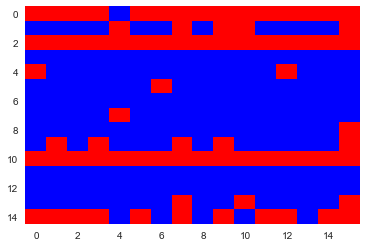

In [512]:
fish_calls = calls.T
state_ix = 12
overlap = list(set(fish_calls.columns)&set(states[state_ix]))
plt.imshow(fish_calls.loc[:,overlap],cmap="bwr",aspect="auto")
plt.grid(False)
print(fish_calls.index)

# Examine clustering algorithm

In [612]:
'''
As the miner.cluster algortihm proceeds, the expression dataframe is
subsetted to look for patterns that may be masked by dominant sample subtypes or features.
The "maxSamplesExcluded" parameter indirectly sets the number of times that
the columns will be subsetted. Each time an iteration completes, the coverage
of each column (i.e., sample) is calculated. The the samples with the best coverage (top 10%)
are removed from the dataframe before the next iteration. If the user wants to set the 
maximum number of samples that can be removed to 30%, then maxExclusion = 0.30. Moreover,
the features (i.e.,genes) that have already been clustered are removed from the dataframe
each iteration.

In order to select for clusters that are most likely of interest, minimum coverage
parameters can be set. "minNumberGenes" sets the minimum number of features (i.e., genes)
that must be present for a cluster to be considered acceptable. Likewise, "minNumberOverExpSamples"
sets the minimum number of samples that must be coherently overexpressed in the cluster.
The threshold that defines overexpressed is set by the "overExpressionThreshold" parameter.
Its default value is 80, meaning that values >= 80th percentile are considered overexpressed.

Because the algorithm has an inherent random feature in the PCA step, the "random_state"
parameter can be set to ensure exact reproducibility.

'''

In [1282]:
def cluster(expressionData,minNumberGenes = 6,minNumberOverExpSamples=4,maxSamplesExcluded=0.50,random_state=12,overExpressionThreshold=80):

    try:
        df = expressionData.copy()
        maxStep = int(np.round(10*maxSamplesExcluded))
        axisSets = []
        allGenesMapped = []
        bestHits = []

        zero = np.percentile(expressionData,0)
        expressionThreshold = np.mean([np.percentile(expressionData.iloc[:,i][expressionData.iloc[:,i]>zero],overExpressionThreshold) for i in range(expressionData.shape[1])])

        startTimer = time.time()
        trial = -1
        for step in range(maxStep):
            trial+=1
            progress = (100./maxStep)*trial
            print('{:.2f} percent complete'.format(progress))
            genesMapped = []
            bestMapped = []

            pca = PCA(10,random_state=random_state)
            principalComponents = pca.fit_transform(df.T)
            principalDf = pd.DataFrame(principalComponents)
            principalDf.index = df.columns

            for i in range(10):
                pearson = pearson_array(np.array(df),np.array(principalDf[i]))
                if len(pearson) == 0:
                    continue
                highpass = max(np.percentile(pearson,95),0.1)
                lowpass = min(np.percentile(pearson,5),-0.1)
                cluster1 = np.array(df.index[np.where(pearson>highpass)[0]])
                cluster2 = np.array(df.index[np.where(pearson<lowpass)[0]])

                for clst in [cluster1,cluster2]:
                    pdc = recursiveAlignment(clst,expressionData=df)
                    if len(pdc)==0:
                        continue
                    elif len(pdc) == 1:
                        genesMapped.append(pdc[0])
                    elif len(pdc) > 1:
                        for j in range(len(pdc)-1):
                            if len(pdc[j]) > minNumberGenes:
                                genesMapped.append(pdc[j])

            allGenesMapped.extend(genesMapped)
            try:
                stackGenes = np.hstack(genesMapped)
            except:
                stackGenes = []
            residualGenes = list(set(df.index)-set(stackGenes))
            df = df.loc[residualGenes,:]

            # computationally fast surrogate for passing the overexpressed significance test:
            for ix in range(len(genesMapped)):
                tmpCluster = expressionData.loc[genesMapped[ix],:]
                tmpCluster[tmpCluster<expressionThreshold] = 0
                tmpCluster[tmpCluster>0] = 1
                sumCluster = np.array(np.sum(tmpCluster,axis=0))
                numHits = np.where(sumCluster>0.333*len(genesMapped[ix]))[0]
                bestMapped.append(numHits)
                if len(numHits)>minNumberOverExpSamples:
                    bestHits.append(genesMapped[ix])

            if len(bestMapped)>0:            
                countHits = Counter(np.hstack(bestMapped))
                ranked = countHits.most_common()
                dominant = [i[0] for i in ranked[0:int(np.ceil(0.1*len(ranked)))]]
                remainder = [i for i in np.arange(df.shape[1]) if i not in dominant]
                df = df.iloc[:,remainder]

        bestHits.sort(key=lambda s: -len(s))

        stopTimer = time.time()
        print('\ncoexpression clustering completed in {:.2f} minutes'.format((stopTimer-startTimer)/60.))

    except:
        print('\nClustering failed. Ensure that expression data is formatted with genes as rows and samples as columns.')
        print('Consider transposing data (expressionData = expressionData.T) and retrying')

    return bestHits


init_clusters = cluster(expressionData,minNumberGenes = 6,minNumberOverExpSamples=4,maxSamplesExcluded=0.50,random_state=12,overExpressionThreshold=80)

0.00 percent complete
20.00 percent complete
40.00 percent complete
60.00 percent complete
80.00 percent complete

coexpression clustering completed in 5.26 minutes


In [1283]:
revisedClusters = miner.reviseInitialClusters(init_clusters,expressionData,threshold=0.925)

(1012, 14838)


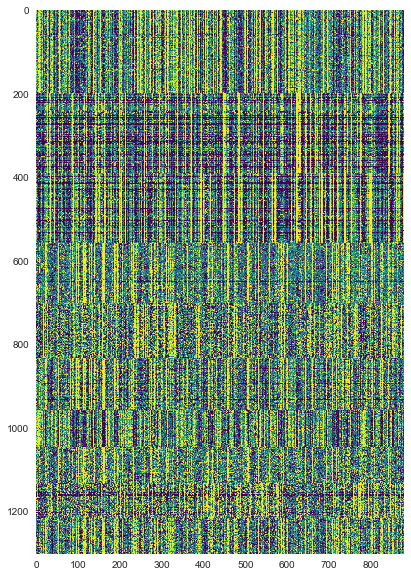

In [1284]:
print(len(revisedClusters),len(set(np.hstack([revisedClusters[key] for key in revisedClusters.keys()]))))
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.grid(False)
plt.imshow(expressionData.loc[np.hstack([revisedClusters[i] for i in range(10)]),:],cmap="viridis",vmin=-1,vmax=1)

# recursiveAlignment()

In [624]:
# Composite function. Depends upon: 
    # i. miner.recursiveDecomposition
    # ii. miner.reconstruction
    
def recursiveAlignment(geneset,expressionData,minNumberGenes=8):
    recDecomp = recursiveDecomposition(geneset,expressionData,minNumberGenes)
    if len(recDecomp) == 0:
        return []
    reconstructed = reconstruction(recDecomp,expressionData)
    reconstructedList = [reconstructed[i] for i in reconstructed.keys() if reconstructed[i]>minNumberGenes]
    reconstructedList.sort(key = lambda s: -len(s))
    return reconstructedList


# 1. recursiveDecomposition(clst,expressionData,minNumberGenes=8)

In [625]:
# Composite function. Depends upon: 
    # i. miner.decompose
    
def recursiveDecomposition(geneset,expressionData,minNumberGenes=8):
    unmixedFiltered = decompose(geneset,expressionData,minNumberGenes=minNumberGenes)   
    if len(unmixedFiltered) == 0:
        return []
    shortSets = [i for i in unmixedFiltered if len(i)<50]
    longSets = [i for i in unmixedFiltered if len(i)>=50]    
    if len(longSets)==0:
        return unmixedFiltered
    for ls in longSets:
        unmixedFiltered = decompose(ls,expressionData,minNumberGenes=minNumberGenes)
        if len(unmixedFiltered)==0:
            continue
        shortSets.extend(unmixedFiltered)
    return shortSets

## 1a. decompose

In [1281]:
# Composite function. Depends upon: 
    # i. miner.FrequencyMatrix
    # ii. miner.unmix
    
#standard default = 85 (now 33.333)
def decompose(geneset,expressionData,minNumberGenes=8): 
    fm = FrequencyMatrix(expressionData.loc[geneset,:])
    tst = np.multiply(fm,fm.T)
    tst[tst<np.percentile(tst,80)]=0
    tst[tst>0]=1
    unmix_tst = unmix(tst)
    unmixedFiltered = [i for i in unmix_tst if len(i)>=minNumberGenes]
    return unmixedFiltered


## 1b. FrequencyMatrix

In [627]:
# Fundamental function (i.e., no function dependencies)

def FrequencyMatrix(matrix,overExpThreshold = 1):
    
    numRows = matrix.shape[0]
    
    if type(matrix) == pd.core.frame.DataFrame:
        index = matrix.index
        matrix = np.array(matrix)
    else:
        index = np.arange(numRows)
    
    matrix[matrix<overExpThreshold] = 0
    matrix[matrix>0] = 1
            
    hitsMatrix = pd.DataFrame(np.zeros((numRows,numRows)))
    for column in range(matrix.shape[1]):
        geneset = matrix[:,column]
        hits = np.where(geneset>0)[0]
        hitsMatrix.iloc[hits,hits] += 1
        
    frequencyMatrix = np.array(hitsMatrix)
    traceFM = np.array([frequencyMatrix[i,i] for i in range(frequencyMatrix.shape[0])]).astype(float)
    if np.count_nonzero(traceFM)<len(traceFM):
        #subset nonzero. computefm. normFM zeros with input shape[0]. overwrite by slice np.where trace>0
        nonzeroGenes = np.where(traceFM>0)[0]
        normFMnonzero = np.transpose(np.transpose(frequencyMatrix[nonzeroGenes,:][:,nonzeroGenes])/traceFM[nonzeroGenes])
        normDf = pd.DataFrame(normFMnonzero)
        normDf.index = index[nonzeroGenes]
        normDf.columns = index[nonzeroGenes]          
    else:            
        normFM = np.transpose(np.transpose(frequencyMatrix)/traceFM)
        normDf = pd.DataFrame(normFM)
        normDf.index = index
        normDf.columns = index   
    
    return normDf

## 1c. unmix

In [628]:
# Fundamental function (i.e., no function dependencies)

def unmix(df,iterations=25,returnAll=False):    
    frequencyClusters = []
    
    for iteration in range(iterations):
        sumDf1 = df.sum(axis=1)
        maxSum = np.argmax(sumDf1)
        hits = np.where(df.loc[maxSum]>0)[0]
        hitIndex = list(df.index[hits])
        block = df.loc[hitIndex,hitIndex]
        blockSum = block.sum(axis=1)
        coreBlock = list(blockSum.index[np.where(blockSum>=np.median(blockSum))[0]])
        remainder = list(set(df.index)-set(coreBlock))
        frequencyClusters.append(coreBlock)
        if len(remainder)==0:
            return frequencyClusters
        if len(coreBlock)==1:
            return frequencyClusters
        df = df.loc[remainder,remainder]
    if returnAll is True:
        frequencyClusters.append(remainder)
    return frequencyClusters


## 1d. f1Binary

In [870]:
def f1Binary(similarityMatrix):

    remainingMembers = set(similarityMatrix.index)
    # probeSample is the sample that serves as a seed to identify a cluster in a given iteration
    probeSample = np.argmax(similarityMatrix.sum(axis=1))
    # members are the samples that satisfy the similarity condition with the previous cluster or probeSample
    members = set(similarityMatrix.index[np.where(similarityMatrix[probeSample]==1)[0]])
    # nonMembers are the remaining members not in the current cluster
    nonMembers = remainingMembers-members
    # instantiate list to collect clusters of similar members
    similarityClusters = []
    # instantiate f1 score for optimization
    f1 = 0

    for iteration in range(1500):

        predictedMembers = members
        predictedNonMembers = remainingMembers-predictedMembers

        sumSlice = np.sum(similarityMatrix.loc[:,list(predictedMembers)],axis=1)/float(len(predictedMembers))
        members = set(similarityMatrix.index[np.where(sumSlice>0.8)[0]])

        if members==predictedMembers:
            similarityClusters.append(list(predictedMembers))
            if len(predictedNonMembers)==0:
                break    
            similarityMatrix = similarityMatrix.loc[predictedNonMembers,predictedNonMembers]
            probeSample = np.argmax(similarityMatrix.sum(axis=1))
            members = set(similarityMatrix.index[np.where(similarityMatrix[probeSample]==1)[0]])
            remainingMembers = predictedNonMembers
            nonMembers = remainingMembers-members
            f1 = 0
            continue

        nonMembers = remainingMembers-members
        TP = len(members&predictedMembers)
        FN = len(predictedNonMembers&members)
        FP = len(predictedMembers&nonMembers)
        tmpf1 = TP/float(TP+FN+FP)

        if tmpf1 <= f1:
            similarityClusters.append(list(predictedMembers))
            if len(predictedNonMembers)==0:
                break
            similarityMatrix = similarityMatrix.loc[predictedNonMembers,predictedNonMembers]
            probeSample = np.argmax(similarityMatrix.sum(axis=1))
            members = set(similarityMatrix.index[np.where(similarityMatrix[probeSample]==1)[0]])
            remainingMembers = predictedNonMembers
            nonMembers = remainingMembers-members
            f1 = 0
            continue   

        elif tmpf1 > f1:
            f1 = tmpf1
            continue
    
    similarityClusters.sort(key = lambda s: -len(s))

    return similarityClusters


In [1192]:
geneset =  np.hstack([initialClusters[10],initialClusters[12],initialClusters[14]])
fm = FrequencyMatrix(expressionData.loc[geneset,:],expressionThreshold)
'''
The frequency matrix gives the row-row frequency of mutual overexpression.
fm[i,j] is the conditional probability that gene j is overexpressied given
that gene i is overexpressed, for a given overexpression threshold defined
by the parameter "overExpThreshold".

The frequency matrix that is returned is not symmetric. In order to arrive
at the symmetric mututal probability of i and j being overexpressed, the 
user can multiply the frequency matrix by its transpose (sym = fm*fm.T)
'''

'\nThe frequency matrix gives the row-row frequency of mutual overexpression.\nfm[i,j] is the conditional probability that gene j is overexpressied given\nthat gene i is overexpressed, for a given overexpression threshold defined\nby the parameter "overExpThreshold".\n\nThe frequency matrix that is returned is not symmetric. In order to arrive\nat the symmetric mututal probability of i and j being overexpressed, the \nuser can multiply the frequency matrix by its transpose (sym = fm*fm.T)\n'

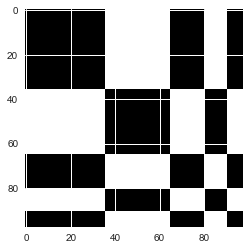

In [1228]:
fm = FrequencyMatrix(expressionData.loc[geneset,:])
tst = np.multiply(fm,fm.T)
tst[tst<np.percentile(tst,75)]=0
tst[tst>0]=1
unmix_tst = unmix(tst)
unmix_tst = f1Binary(tst)
unmixedFiltered = [i for i in unmix_tst if len(i)>=minNumberGenes]

unmixedFiltered = decompose(geneset,expressionData,minNumberGenes=6)
plt.imshow(tst.loc[np.hstack(unmixedFiltered),np.hstack(unmixedFiltered)])

# 2. reconstruction

In [629]:
# Composite function. Depends upon: 
    # i. miner.getAxes
    # ii. miner.combineClusters

def reconstruction(decomposedList,expressionData,threshold=0.925):
    clusters = {i:decomposedList[i] for i in range(len(decomposedList))}
    axes = getAxes(clusters,expressionData)
    recombine = combineClusters(axes,clusters,threshold)
    return recombine

## 2a. getAxes

In [630]:
# Fundamental function (i.e., no function dependencies)

def getAxes(clusters,expressionData):
    axes = {}
    for key in clusters.keys():
        genes = clusters[key]
        fpc = PCA(1)
        principalComponents = fpc.fit_transform(expressionData.loc[genes,:].T)
        axes[key] = principalComponents.ravel()
    return axes

## 2b. combineClusters

In [631]:
# Composite function. Depends upon: 
    # i. miner.pearson_array
    # ii. miner.decomposeDictionaryToLists

def combineClusters(axes,clusters,threshold=0.925):
    combineAxes = {}
    filterKeys = np.array(axes.keys())
    axesMatrix = np.vstack([axes[i] for i in filterKeys])
    for key in filterKeys:
        axis = axes[key]
        pearson = pearson_array(axesMatrix,axis)
        combine = np.where(pearson>threshold)[0]
        combineAxes[key] = filterKeys[combine]
     
    revisedClusters = {}
    combinedKeys = decomposeDictionaryToLists(combineAxes)
    for keyList in combinedKeys:
        genes = list(set(np.hstack([clusters[i] for i in keyList])))
        revisedClusters[len(revisedClusters)] = genes

    return revisedClusters

## 2c. pearson_array

In [632]:
# Fundamental function (i.e., no function dependencies)

def pearson_array(array,vector):
    
    #r = (1/n-1)sum(((x-xbar)/sx)((y-ybar)/sy))
    
    ybar = np.mean(vector)
    sy = np.std(vector,ddof=1)    
    yterms = (vector-ybar)/float(sy)
    
    array_sx = np.std(array,axis=1,ddof=1)
    
    if 0 in array_sx:
        passIndex = np.where(array_sx>0)[0]
        array = array[passIndex,:]
        array_sx = array_sx[passIndex]
        
    array_xbar = np.mean(array,axis=1)            
    product_array = np.zeros(array.shape)
    
    for i in range(0,product_array.shape[1]):
        product_array[:,i] = yterms[i]*(array[:,i] - array_xbar)/array_sx
        
    return np.sum(product_array,axis=1)/float(product_array.shape[1]-1)


## 2d. decomposeDictionaryToLists

In [633]:
# Composite function. Depends upon: 
    # i. miner.iterativeCombination

def decomposeDictionaryToLists(dict_):
    decomposedSets = []
    for key in dict_.keys():
        newSet = iterativeCombination(dict_,key,iterations=25)
        if newSet not in decomposedSets:
            decomposedSets.append(newSet)
    return decomposedSets

## 2e. iterativeCombination

In [634]:
# Fundamental function (i.e., no function dependencies)

def iterativeCombination(dict_,key,iterations=25):
    
    initial = dict_[key]
    initialLength = len(initial)
    for iteration in range(iterations):
        revised = [i for i in initial]
        for element in initial:
            revised = list(set(revised)|set(dict_[element]))
        revisedLength = len(revised)
        if revisedLength == initialLength:
            return revised
        elif revisedLength > initialLength:
            initial = [i for i in revised]
            initialLength = len(initial)
    return revised

# Perform functional enrichment analyses

In [702]:
#ppi_enriched: genes are enriched with interacting partners for the corresponding gene key
ppi_enriched = miner.enrichmentAnalysis(regulonModules,"protein_interactions.pkl","protein_interactions.pkl",genes_with_expression = expressionData.index,resultsDirectory=resultsDirectory,min_overlap=3,threshold=0.05)
#pathways_enriched: genes are enriched with pathway members for the corresponding pathway key
pathways_enriched = miner.enrichmentAnalysis(regulonModules,"pathways.pkl","pathways_reciprocal.pkl",genes_with_expression = expressionData.index,resultsDirectory=resultsDirectory,min_overlap=3,threshold=0.05)
#goBio_enriched: genes are enriched with members of the biological process corresponding to the key
goBio_enriched = miner.enrichmentAnalysis(regulonModules,"GO_bio.pkl","GO_bio_reciprocal.pkl",genes_with_expression = expressionData.index,resultsDirectory=resultsDirectory,numCores=5,min_overlap=3,threshold=0.05)
#convert keys from GO symbols to GO functions for interpretability
go_terms_enriched = miner.convertGO(goBio_enriched,resultsDirectory)

initializing enrichment analysis
completed enrichment analysis in 2.48 seconds
initializing enrichment analysis
completed enrichment analysis in 4.19 seconds
initializing enrichment analysis
completed enrichment analysis in 25.10 seconds


In [703]:
#write results of enrichment analyses
miner.write_json(ppi_enriched,output_file=os.path.join(resultsDirectory,"ppi_enrichment.json"))
miner.write_json(pathways_enriched,output_file=os.path.join(resultsDirectory,"pathways_enrichment.json"))
miner.write_json(goBio_enriched,output_file=os.path.join(resultsDirectory,"GO_bio_enrichment_symbols.json"))
miner.write_json(go_terms_enriched,output_file=os.path.join(resultsDirectory,"GO_bio_enrichment.json"))

In [708]:
reload(miner)
#ppi_enriched: genes are enriched with interacting partners for the corresponding gene key
ppi_enriched_programs = miner.enrichmentAnalysis(transcriptional_programs,"protein_interactions.pkl","protein_interactions.pkl",genes_with_expression = expressionData.index,resultsDirectory=resultsDirectory,min_overlap=3,threshold=0.05)
#pathways_enriched: genes are enriched with pathway members for the corresponding pathway key
pathways_enriched_programs = miner.enrichmentAnalysis(transcriptional_programs,"pathways.pkl","pathways_reciprocal.pkl",genes_with_expression = expressionData.index,resultsDirectory=resultsDirectory,min_overlap=3,threshold=0.05)
#goBio_enriched: genes are enriched with members of the biological process corresponding to the key
goBio_enriched_programs = miner.enrichmentAnalysis(transcriptional_programs,"GO_bio.pkl","GO_bio_reciprocal.pkl",genes_with_expression = expressionData.index,resultsDirectory=resultsDirectory,numCores=5,min_overlap=3,threshold=0.05)
#convert keys from GO symbols to GO functions for interpretability
go_terms_enriched_programs = miner.convertGO(goBio_enriched_programs,resultsDirectory)

initializing enrichment analysis
completed enrichment analysis in 5.17 seconds
initializing enrichment analysis
completed enrichment analysis in 12.47 seconds
initializing enrichment analysis
completed enrichment analysis in 51.40 seconds


In [711]:
pathways_enriched_programs

{'TP18': {'REACTOME_INTERFERON_ALPHA_BETA_SIGNALING': 0.0012984620689075507,
  'REACTOME_INTERFERON_SIGNALING': 0.03239619313494989},
 'TP5': {'PID_TOLL_ENDOGENOUS_PATHWAY': 0.001912696247269076}}

In [218]:
#write results of enrichment analyses
miner.write_json(ppi_enriched_programs,output_file=os.path.join(resultsDirectory,"ppi_programs_enrichment.json"))
miner.write_json(pathways_enriched_programs,output_file=os.path.join(resultsDirectory,"pathways_programs_enrichment.json"))
miner.write_json(goBio_enriched_programs,output_file=os.path.join(resultsDirectory,"GO_bio_programs_enrichment_symbols.json"))
miner.write_json(go_terms_enriched_programs,output_file=os.path.join(resultsDirectory,"GO_bio_programs_enrichment.json"))

In [224]:
reference_dict = "GO_bio.pkl"
reciprocal_dict = "GO_bio_reciprocal.pkl"

os.chdir(os.path.join(resultsDirectory,"..","data","network_dictionaries"))
reference_dict = miner.read_pkl(reference_dict)
reciprocal_dict = miner.read_pkl(reciprocal_dict)
os.chdir(os.path.join(resultsDirectory,"..","src"))

print(len(reciprocal_dict.keys()))

9760


In [705]:
go_terms_enriched

{'108': {'Roundabout signaling pathway': 0.06780468098085049,
  'apoptotic process involved in luteolysis': 0.06780468098085049,
  'luteolysis': 0.06780468098085049},
 '135': {'cellular response to type I interferon': 0.03890690969508441,
  'response to type I interferon': 0.03890690969508441,
  'response to virus': 0.020813582630879717,
  'type I interferon signaling pathway': 0.03890690969508441},
 '201': {'semaphorin-plexin signaling pathway involved in neuron projection guidance': 0.06255739085978726,
  'sympathetic neuron projection extension': 0.06255739085978726,
  'sympathetic neuron projection guidance': 0.06255739085978726},
 '219': {'Roundabout signaling pathway': 0.018262887658181137,
  'apoptotic process involved in development': 0.09345051579595075,
  'apoptotic process involved in luteolysis': 0.018262887658181137,
  'luteolysis': 0.018262887658181137,
  'negative chemotaxis': 0.06370538491402093,
  'negative regulation of chemokine-mediated signaling pathway': 0.0455804

# Survival analysis

In [190]:
# load survival data
survivalMMRF = pd.read_csv(os.path.join("..","data","survivalIA12.csv"),index_col=0,header=0)
survivalDfMMRF = survivalMMRF.iloc[:,0:2]
survivalDfMMRF.columns = ["duration","observed"]
overExpressedMembersMatrixMMRF = overExpressedMembersMatrix
overExpressedMembersMatrixMMRF = overExpressedMembersMatrixMMRF.loc[orderedOverExpressedMembers.index,:]

In [191]:
#generate Kaplan-Meier estimates
kmDf = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfMMRF = miner.guanRank(kmSurvival=kmDf)

In [651]:
states_copy = [i for i in states]

19


Text(0,0.5,u'Risk score')

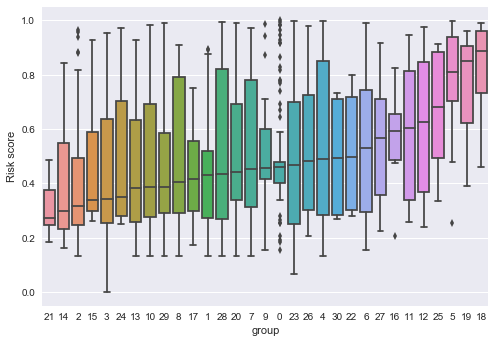

In [652]:
srv = guanSurvivalDfMMRF.copy()
guan_srv = pd.DataFrame(srv.loc[:,"GuanScore"])
guan_srv.columns = ["value"]
guan_srv_group = pd.DataFrame(np.zeros(guan_srv.shape[0]))
guan_srv_group.index = guan_srv.index
guan_srv_group.columns = ["group"]
guan_srv_df = pd.concat([guan_srv,guan_srv_group],axis=1)


mmrf_groups = states_copy #[states_copy[i] for i in sufficient_groups]
#groups.sort(key = lambda s: -len(s))
labels = range(len(mmrf_groups))
x_medians = []
for i in range(len(mmrf_groups)):
    group = list(set(srv.index)&set(mmrf_groups[i]))
    if len(group)>=1:
        x_medians.append(np.median(guan_srv_df.loc[group,"value"]))
    elif len(group)<1:
        x_medians.append(0)
    label = labels[i]
    guan_srv_df.loc[group,"group"] = label
print(len(medians))
    
import seaborn as sns
survival_tag = "MMRF_revised"
sns.boxplot(x='group', y='value', data=guan_srv_df,order=np.argsort(x_medians))
plt.ylabel("Risk score")
#boxplotFilename = ("_").join([survival_tag,"boxplot.pdf"])
#plt.savefig(os.path.join(resultsDirectory,boxplotFilename),bbox_inches="tight")

In [662]:
len(states_copy[2])

82

In [318]:
min_size = 5
sufficient_groups = []
for i in range(len(states)):
    if len(mmrf_groups[i]) >= min_size:
        if len(uams_groups[i]) >= min_size:
            sufficient_groups.append(i)
            

In [287]:
mmrf_ordered = np.argsort(medians)

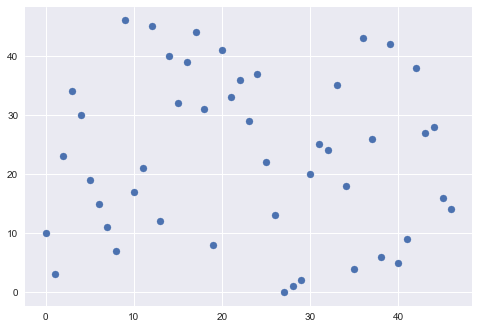

In [292]:
plt.scatter(mmrf_ordered,uams_medians)

# Validation datasets

## Process expression data

In [232]:
# GSE24080UAMS
expressionDataGSE24080UAMS = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","GSE24080UAMSentrezIDlevel.csv"),index_col=0,header=0)
expressionDataGSE24080UAMS, _ = miner.identifierConversion(expressionData=expressionDataGSE24080UAMS)
expressionDataGSE24080UAMS = miner.zscore(expressionDataGSE24080UAMS)
bkgdGSE24080UAMS = miner.backgroundDf(expressionDataGSE24080UAMS)
overExpressedMembersGSE24080UAMS = miner.biclusterMembershipDictionary(regulonModules,bkgdGSE24080UAMS,label=2)
overExpressedMembersMatrixGSE24080UAMS = miner.membershipToIncidence(overExpressedMembersGSE24080UAMS,expressionDataGSE24080UAMS)
overExpressedMembersMatrixGSE24080UAMS = overExpressedMembersMatrixGSE24080UAMS.loc[orderedOverExpressedMembers.index,:]

# GSE19784HOVON65 
expressionDataGSE19784HOVON65 = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","GSE19784HOVON65entrezIDlevel.csv"),index_col=0,header=0)
expressionDataGSE19784HOVON65, _ = miner.identifierConversion(expressionData=expressionDataGSE19784HOVON65)
expressionDataGSE19784HOVON65 = miner.zscore(expressionDataGSE19784HOVON65)
bkgdGSE19784HOVON65 = miner.backgroundDf(expressionDataGSE19784HOVON65)
overExpressedMembersGSE19784HOVON65 = miner.biclusterMembershipDictionary(regulonModules,bkgdGSE19784HOVON65,label=2)
overExpressedMembersMatrixGSE19784HOVON65 = miner.membershipToIncidence(overExpressedMembersGSE19784HOVON65,expressionDataGSE19784HOVON65)
overExpressedMembersMatrixGSE19784HOVON65 = overExpressedMembersMatrixGSE19784HOVON65.loc[orderedOverExpressedMembers.index,:]

# EMTAB4032
expressionDataEMTAB4032 = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","EMTAB4032entrezIDlevel.csv"),index_col=0,header=0)
expressionDataEMTAB4032, _ = miner.identifierConversion(expressionData=expressionDataEMTAB4032)
expressionDataEMTAB4032 = miner.zscore(expressionDataEMTAB4032)
bkgdEMTAB4032 = miner.backgroundDf(expressionDataEMTAB4032)
overExpressedMembersEMTAB4032 = miner.biclusterMembershipDictionary(regulonModules,bkgdEMTAB4032,label=2)
overExpressedMembersMatrixEMTAB4032 = miner.membershipToIncidence(overExpressedMembersEMTAB4032,expressionDataEMTAB4032)
overExpressedMembersMatrixEMTAB4032 = overExpressedMembersMatrixEMTAB4032.loc[orderedOverExpressedMembers.index,:]

completed identifier conversion.
16998 genes were converted.
completed z-transformation.
done!
completed identifier conversion.
16998 genes were converted.
completed z-transformation.
done!
completed identifier conversion.
17228 genes were converted.
completed z-transformation.
done!


## Process survival data

In [233]:
survival = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","globalClinTraining.csv"),index_col=0,header=0)

survivalGSE24080UAMS = survival[survival.index=='GSE24080UAMS']
survivalGSE24080UAMS.index = survivalGSE24080UAMS.iloc[:,0]
survivalGSE24080UAMS.head(3)
survivalDfGSE24080UAMS = survivalGSE24080UAMS.loc[:,["D_PFS","D_PFS_FLAG"]]
survivalDfGSE24080UAMS.columns = ["duration","observed"]

survivalGSE19784HOVON65 = survival[survival.index=='HOVON65']
survivalGSE19784HOVON65.index = survivalGSE19784HOVON65.iloc[:,0]
survivalGSE19784HOVON65.head(3)
survivalDfGSE19784HOVON65 = survivalGSE19784HOVON65.loc[:,["D_PFS","D_PFS_FLAG"]]
survivalDfGSE19784HOVON65.columns = ["duration","observed"]

survivalEMTAB4032 = survival[survival.index=='EMTAB4032']
survivalEMTAB4032.index = survivalEMTAB4032.iloc[:,0]
survivalEMTAB4032.head(3)
survivalDfEMTAB4032 = survivalEMTAB4032.loc[:,["D_PFS","D_PFS_FLAG"]]
survivalDfEMTAB4032.columns = ["duration","observed"]

In [234]:
#generate Kaplan-Meier estimates
kmDf = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfMMRF = miner.guanRank(kmSurvival=kmDf)

#generate Kaplan-Meier estimates for GuanRank analysis
kmDf = miner.kmAnalysis(survivalDf=survivalDfGSE24080UAMS,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfGSE24080UAMS = miner.guanRank(kmSurvival=kmDf)

#generate Kaplan-Meier estimates for GuanRank analysis
kmDf = miner.kmAnalysis(survivalDf=survivalDfGSE19784HOVON65,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfGSE19784HOVON65 = miner.guanRank(kmSurvival=kmDf)

#generate Kaplan-Meier estimates for GuanRank analysis
kmDf = miner.kmAnalysis(survivalDf=survivalDfEMTAB4032,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfEMTAB4032 = miner.guanRank(kmSurvival=kmDf)

'TP225'

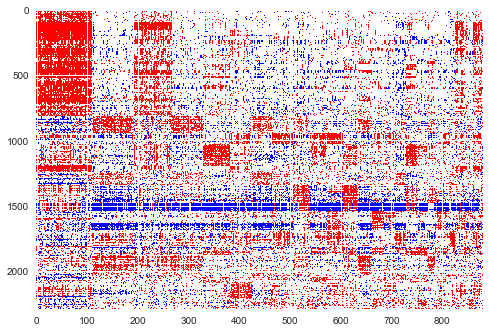

In [278]:
ordered_keys = [("").join(["TP",str(i)]) for i in range(len(program_regulons))]
ordered_regulons = np.hstack([program_regulons[i] for i in ordered_keys])
plt.imshow(difference_complete.loc[ordered_regulons,np.hstack(states)],cmap="bwr",aspect="auto")
program_regulons.keys()[0]

done!
done!


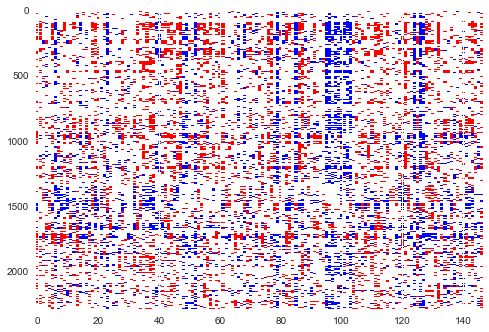

In [396]:
overExpressedMembersEMTAB4032 = miner.biclusterMembershipDictionary(regulonModules,bkgdEMTAB4032,label=2)
underExpressedMembersEMTAB4032 = miner.biclusterMembershipDictionary(regulonModules,bkgdEMTAB4032,label=0)
overExpressedMembersMatrixEMTAB4032 = miner.membershipToIncidence(overExpressedMembersEMTAB4032,expressionDataEMTAB4032)
underExpressedMembersMatrixEMTAB4032 = miner.membershipToIncidence(underExpressedMembersEMTAB4032,expressionDataEMTAB4032)

difference_complete_EMTAB4032 = overExpressedMembersMatrixEMTAB4032-underExpressedMembersMatrixEMTAB4032
difference_complete_EMTAB4032 = difference_complete_EMTAB4032.loc[ordered_regulons,:]
plt.imshow(difference_complete_EMTAB4032.loc[ordered_regulons,:],cmap="bwr",aspect="auto")

In [252]:
def getCentroids(classes,sampleMatrix):
    centroids = []
    for i in range(len(classes)):
        clusterComponents = sampleMatrix.loc[:,classes[i]]
        class1 = np.mean(clusterComponents,axis=1)
        centroid = pd.DataFrame(class1)
        centroid.columns = [i]
        centroid.index = sampleMatrix.index
        centroids.append(centroid)
    return pd.concat(centroids,axis=1)
centroids_mmrf = getCentroids(states,difference_complete)

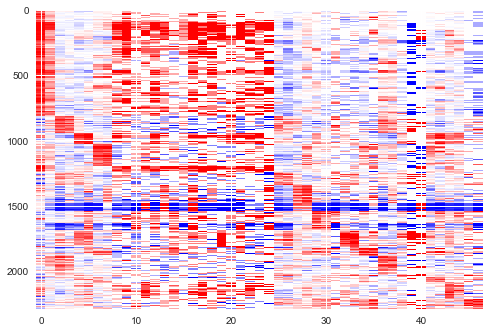

In [254]:
plt.imshow(centroids_mmrf.loc[ordered_regulons,:],cmap="bwr",aspect="auto")

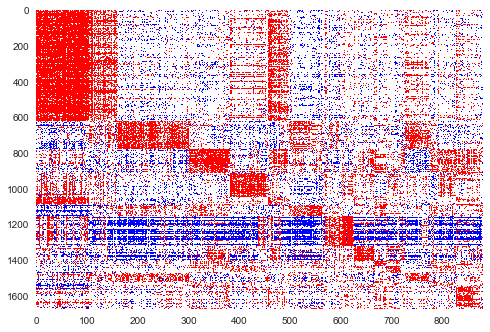

In [664]:
centroid_mapping = [[] for i in range(len(centroidClusters))]
ordered_patients = np.hstack(states)
for i in range(len(ordered_patients)):
    corr_ = miner.pearson_array(array=np.array(centroidMatrix.loc[ordered_regulons,:]).T,vector=np.array(difference_complete.loc[ordered_regulons,ordered_patients[i]]))
    centroid_mapping[np.argmax(corr_)].append(ordered_patients[i])
    
plt.imshow(difference_complete.loc[orderedDM.index,np.hstack(centroid_mapping)],cmap="bwr",aspect="auto")
plt.grid(False)
plt.savefig(os.path.join(resultsDirectory,"centroid_map_o2_MMRF_revised.pdf"))

In [935]:
centroid_mapping = [[] for i in range(len(centroidClusters))]
ordered_patients = np.hstack(difference_complete_GSE24080UAMS.columns)
for i in range(len(ordered_patients)):
    corr_ = miner.pearson_array(array=np.array(centroidMatrix.loc[ordered_regulons,:]).T,vector=np.array(difference_complete_GSE24080UAMS.loc[ordered_regulons,ordered_patients[i]]))
    centroid_mapping[np.argmax(corr_)].append(ordered_patients[i])
    
plt.imshow(difference_complete_GSE24080UAMS.loc[orderedDM.index,np.hstack(centroid_mapping)],cmap="bwr",aspect="auto")

NameError: name 'difference_complete_GSE24080UAMS' is not defined

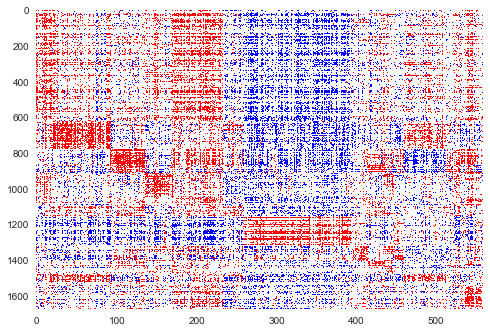

In [562]:
plt.imshow(difference_complete_GSE24080UAMS.loc[orderedDM.index,np.hstack(centroid_mapping)],cmap="bwr",aspect="auto")
plt.grid(False)
plt.savefig(os.path.join(resultsDirectory,"centroid_map_o2_GSE24080UAMS_revised.pdf"))

{'boxes': [<matplotlib.lines.Line2D at 0x1a75c0f790>],
 'caps': [<matplotlib.lines.Line2D at 0x1a75c0ffd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a75c33b50>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1a75c33790>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1a75c0f850>,
  <matplotlib.lines.Line2D at 0x1a75c0fc10>]}

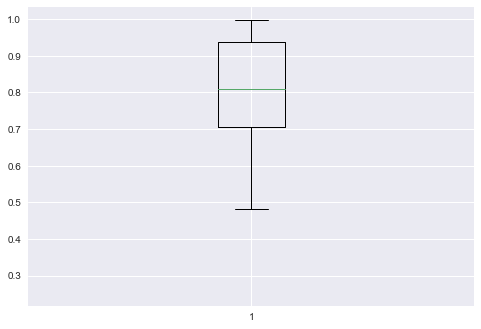

In [563]:
plt.boxplot(guanSurvivalDfMMRF.loc[list(set(states[5])&set(guanSurvivalDfMMRF.index)),"GuanScore"])

# CCND1: [6,7,34,41,28] = [mod high but dispersed; average but dispersed; low; average but dispersed; mod low but dispersed]
# Mix: [0,1] = [average and tight; mod low but dispersed]
# WHSC1: [29,30,5] = [average but dispersed; mod low; very high]

In [531]:
mutations = pd.read_csv(os.path.join(resultsDirectory,"..","data","filteredMutationsIA12.csv"),index_col=0,header=0)

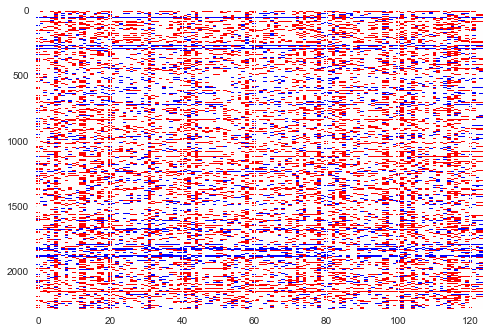

In [517]:
#mutations = pd.read_csv(os.path.join(resultsDirectory,"..","data","translocationsIA12.csv"),index_col=0,header=0)

ix=0
whsc1_pats = mutations.columns[mutations.loc["RNASeq_WHSC1_Call",:]==1]
plt.imshow(difference_complete.loc[:,whsc1_pats],cmap="bwr",aspect="auto")
whsc1_mutations = mutations.loc[:,mutations.loc["RNASeq_WHSC1_Call",:]==1]

# whsc1 with: '742' == {-1,0,1}
# 
#
high_742 = difference_complete.columns[np.where(difference_complete.loc['742',whsc1_pats]==1)[0]]
mid_742 = difference_complete.columns[np.where(difference_complete.loc['742',whsc1_pats]==0)[0]]
low_742 = difference_complete.columns[np.where(difference_complete.loc['742',whsc1_pats]==-1)[0]]



In [504]:
whsc1_mutations
whsc1_survival = survivalDfMMRF.loc[list(set(survivalDfMMRF.index)&set(whsc1_pats)),:]
srv = whsc1_survival.copy()
cox_whsc1 = miner.parallelMemberSurvivalAnalysis(membershipDf = difference_complete.loc[:,whsc1_pats],numCores=5,survivalPath="",survivalData=srv)
print(cox_whsc1)

10
10
10
10
10
20
20
20
20
20


/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) ['1395'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)


30
30
30
30
30
40
40
40
40
40
50
50
50
50
50
60
60
60
60
60


/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Column(s) ['1895'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails.
  warnings.warn(warning_text, RuntimeWarning)
/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) ['1895'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)


70
70
70
70
70
80
80
80
80
80


/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) ['1459'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)


90
90
90
90
90


/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) ['96'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)


100
100
100
100
100


/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) ['559'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)


110
110
110
110
110
120
120
120
120
120
130
130
130
130
130


/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) ['1509'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)


140
140
140
140
140
150
150
150
150
150


/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) ['1070'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)


160
160
160
160
160
170
170
170
170
170
180
180
180
180
180
190
190
190
190
190
200
200
200
200


/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) ['657'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)


200


/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) ['2034'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)


210
210
210
210
210
220
220
220
220
220


/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) ['1138'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)


230
230
230
230
230
240


/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) ['238'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)


240
240
240
240
250
250
250
250
250
260
260
260
260
260
270
270
270
270
270
280
280
280
280
280
290
290
290
290
290
300
300
300
300
300
310
310
310
310
310


/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) ['1226'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)


320
320
320
320
320


/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) ['2157'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)


330
330
330
330
330
340
340
340
340
340
350
350
350
350
350
360
360
360
360
360
370
370
370
370
370
380
380
380
380
380
390
390
390
390
390
400
400
400
400
400
410
410
410
410
410
420
420
420
420
420
430
430
430
430
430


/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Column(s) ['1811'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails.
  warnings.warn(warning_text, RuntimeWarning)
/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) ['1811'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)


440
440
440
440
440
450
450
450
450
450
{'344': (0.7407080458885152, 0.458870479828245), '345': (-0.508950591092327, 0.6107868572691746), '346': (1.461924111586199, 0.14376200681822376), '347': (-0.8443904166686563, 0.3984512757775347), '340': (0.07182137695209842, 0.9427440604032284), '341': (1.6811023016740356, 0.09274304541545114), '342': (1.958434199844681, 0.05017908502001288), '343': (0.5741807931317677, 0.5658454651690531), '348': (-1.6644071194449968, 0.0960310982872091), '349': (0.8972305313406295, 0.36959591662971125), '298': (2.7570648246196447, 0.005832278788814021), '299': (0.40409809190669305, 0.6861405880476359), '296': (2.46326391526831, 0.01376785321574124), '297': (3.63878072043136, 0.00027393191869015524), '294': (-1.7491854725138618, 0.0802589644268792), '295': (-1.436755284871812, 0.15078753998890024), '292': (-1.8201794087340106, 0.06873168781533379), '293': (3.108678375954652, 0.0018792616795066776), '290': (-1.7110850891652918, 0.08706540632042868), '291': (0.66

# Begin construction zone

In [507]:
cox_whsc1_hits = {}
for key in cox_whsc1.keys():
    if cox_whsc1[key][1]<0.00001:
        cox_whsc1_hits[key] = cox_whsc1[key]
print(cox_whsc1_hits)  

{'742': (6.162763325778543, 7.148631395407826e-10), '1314': (4.512935557409854, 6.3936453398378065e-06), '861': (5.809182516227291, 6.277862097436321e-09), '464': (4.610370474491731, 4.0195201468260005e-06), '758': (4.536151085084777, 5.7290145796525e-06), '1847': (4.786762225668722, 1.6949343967171018e-06), '978': (4.797379915396696, 1.6075452361629476e-06), '526': (4.857740714956883, 1.187327486618402e-06), '1242': (4.448187538400249, 8.659790661595221e-06), '1951': (4.9706270884052, 6.673669954471106e-07), '736': (4.425611174423675, 9.616961194340166e-06), '2061': (4.679748286510994, 2.872273337176583e-06), '307': (4.536151085084777, 5.7290145796525e-06), '2160': (4.9489279422106325, 7.462336538454879e-07), '926': (5.1712038172326755, 2.3259070443523137e-07), '2265': (4.862602144576036, 1.1585256005746334e-06)}


In [546]:
ix = 26
muts_ = mutations.loc[:,list(set(states[ix])&set(mutations.columns))].sum(axis=1)
muts_.sort_values(ascending=False,inplace=True)
print(muts_/float(len(set(states[ix])&set(mutations.columns))))
print(float(len(set(states[ix])&set(mutations.columns)))/mutations.shape[1])
print(float(len(set(states[ix])&set(mutations.columns))))
print(len(states))

#0: 0.306 CCND1, 0.162 WHSC1, 111 pats (0.072 MAF, 0.045 MYC)
#1: 0.236 CCND1, 0.079 WHSC1, 76 pats (0.026 MYC)
#5: 0.065 CCND1, 0.903 WHSC1, 31 pats (0.097 MYC)
#6: 0.923 CCND1, 0.000 WHSC1, 52 pats (0.019 MYC)
#7: 0.900 CCND1, 0.000 WHSC1, 20 pats (0.100 CCND3)
#10*: 0.000 CCND1, 1.000 WHSC1, 3 pats
#11*: 0.000 CCND1, 1.000 MAF, 3 pats
#12*: 0.000 CCND1, 1.000 WHSC1, 3 pats
#30: 0.000 CCND1, 0.933 WHSC1, 15 pats

#25: 0.024 CCND1, 0.024 WHSC1, 41 pats
#26: 0.095 CCND1, 0.476 MYC, 21 pats
#28: 0.483 CCND1, 0.034 WHSC1, 29 pats
#29: 0.000 CCND1, 1.000 WHSC1, 23 pats (0.870 FGFR3)
#34: 0.750 CCND1, 0.000 WHSC1, 20 pats (0.150 CCND2, 0.050 CCND3)
#41: 0.559 CCND1, 0.000 WHSC1, 34 pats (0.147 CCND3, 0.0882 MYC)
#43: 0.000 CCND1, 0.0698 WHSC1 (0.000 FGFR3), 43 pats (0.488 MAF, 0.233 MAFA, 0.186 MAFB)

# CCND1: [6,7,34,41,28,0*,1*]
# WHSC1: [29,30,5]

KRAS        0.315789
NRAS        0.263158
MUC16       0.263158
HUWE1       0.210526
LRP1B       0.157895
EP400       0.157895
SYNE1       0.157895
LPHN2       0.157895
COL1A1      0.157895
USH2A       0.157895
NBEAL2      0.157895
PARD3       0.157895
SOX9        0.157895
TRAF3       0.157895
CSMD3       0.157895
TTN         0.157895
DNAH14      0.157895
ANO5        0.105263
KANSL1L     0.105263
DNAH6       0.105263
IRX2        0.105263
METAP2      0.105263
EVPL        0.105263
ADAMTS20    0.105263
PCSK5       0.105263
CDC42BPA    0.105263
NUP98       0.105263
CCNB3       0.105263
TCHHL1      0.105263
TENM1       0.105263
              ...   
INO80D      0.000000
NAV1        0.000000
HDLBP       0.000000
C2          0.000000
ST6GAL2     0.000000
CFH         0.000000
TNS3        0.000000
TGFBR3      0.000000
ICOSLG      0.000000
ZNF229      0.000000
PPP1R9A     0.000000
HIST1H1C    0.000000
ACTN2       0.000000
WDR64       0.000000
MTPAP       0.000000
NSD1        0.000000
CDK11A      0

50
100
150
200
250


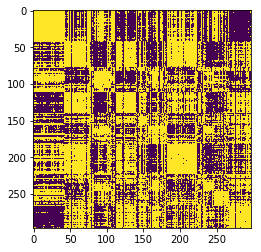

In [110]:
reload(miner)
normDf = miner.featureFrequencyMatrix(statesDf,frequencies=True)
plt.imshow(normDf)

In [106]:
reload(miner)
featureDecomposition = miner.f1Decomposition(sampleMembers=None,thresholdSFM=0.1,sampleFrequencyMatrix=normDf)

done!


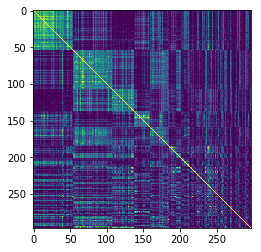

In [107]:
plt.imshow(normDf.loc[np.hstack(featureDecomposition),np.hstack(featureDecomposition)])

# Begin exploratory analysis for unsolved problems

In [6655]:
len(np.where(np.count_nonzero(statesDf,axis=0)==0)[0])/float(statesDf.shape[1])

0.04976303317535545

## Visualize sample subtypes with tSNE

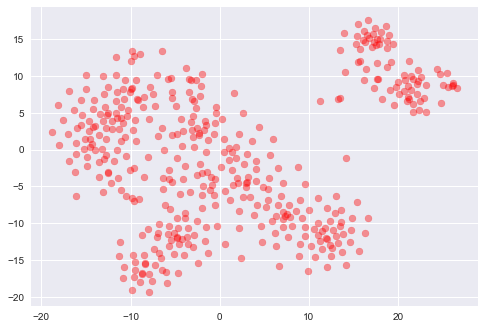

In [6419]:
# tSNE applied to expressionData. Set plotOnly = False to return tSNE coordinates
# consider changing the perplexity to explore different degrees of cluster separation
miner.tsne(expressionData,perplexity=15,n_components=2,n_iter=1000,plotOnly=True,plotColor="red",alpha=0.4)

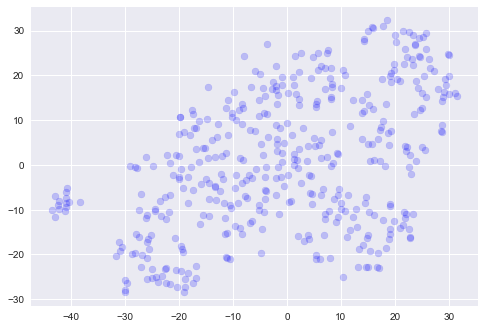

In [806]:
# tSNE applied to orderedOverExpressedMembers. Consider changing the perplexity in the range of 5 to 50
#cl = centroidClusters[9]
X_embedded = miner.tsne(statesDf,perplexity=12,n_components=2,n_iter=500,plotOnly=None,plotColor="blue",alpha=0.2)
tsneDf = pd.DataFrame(X_embedded)
tsneDf.index = statesDf.columns
tsneDf.columns = ["tsne1","tsne2"]
#plt.savefig(os.path.join(resultsDirectory,"tsne_metaregulons_o3.pdf"),bbox_inches="tight")

In [807]:
il13ra2 = "ENSG00000123496"
receptor_expression = np.array(expressionData.loc[il13ra2,tsneDf.index])

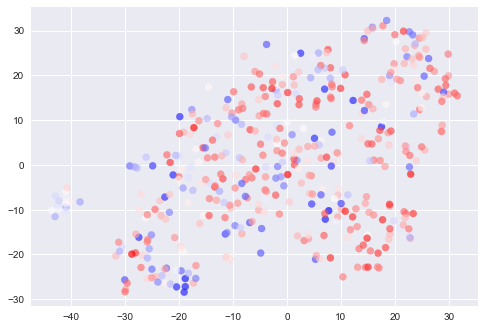

In [808]:
# define subtypes by clustering tsne plot

# How many clusters do you expect?
numberOfClusters = 10

# Are the clusters separated how you thought? If not, change the random_state to a different number and retry
random_state=0

clusters, labels, centroids = miner.kmeans(tsneDf,numClusters=numberOfClusters,random_state=random_state)
plt.scatter(tsneDf.iloc[:,0],tsneDf.iloc[:,1],cmap="bwr",c=receptor_expression,alpha=0.65)
#plt.savefig(os.path.join(resultsDirectory,"labeled_tsne_il13ra2_o3.pdf"),bbox_inches="tight")

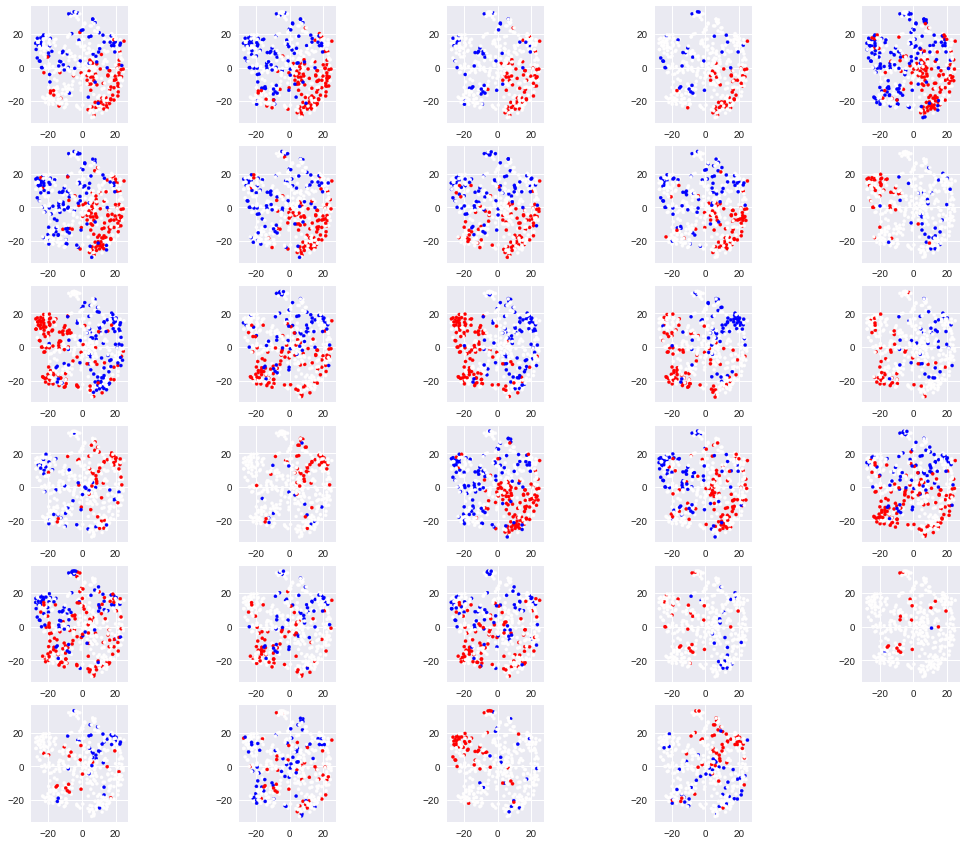

In [757]:
#plot all states onto single stitched output
reload(miner)
miner.plotStates(statesDf,tsneDf,numCols=5,numRows=6,saveFile = os.path.join(resultsDirectory,"states_metaregulons_o3_test.pdf"),size=10,aspect=1,scale=3)

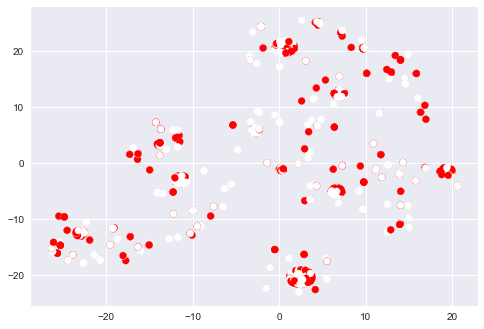

In [5873]:
# overlay single regulon activity onto tSNE
key_index = 10
moduleKey = referenceDictionary.keys()[key_index]
plt.scatter(X_embedded[:,0],X_embedded[:,1],cmap="bwr",c=np.array(sampleMatrix.loc[moduleKey,:]),vmin=-1,vmax=1)

# Next: Build predictor from state space df

# Warning: this will only run after survival analysis

19


Text(0,0.5,u'PFS GuanRank')

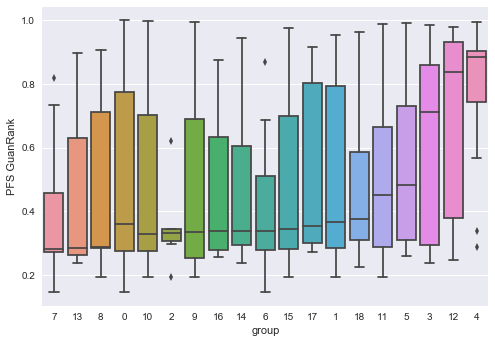

In [325]:
srv = guanSurvivalDfGSE24080UAMS.copy()
guan_srv = pd.DataFrame(srv.loc[:,"GuanScore"])
guan_srv.columns = ["value"]
guan_srv_group = pd.DataFrame(np.zeros(guan_srv.shape[0]))
guan_srv_group.index = guan_srv.index
guan_srv_group.columns = ["group"]
guan_srv_df = pd.concat([guan_srv,guan_srv_group],axis=1)


uams_groups = [centroid_mapping[i] for i in sufficient_groups]
#groups.sort(key = lambda s: -len(s))
labels = range(len(uams_groups))
medians = []
for i in range(len(uams_groups)):
    group = list(set(srv.index)&set(uams_groups[i]))
    if len(group)>=1:
        medians.append(np.median(guan_srv_df.loc[group,"value"]))
    elif len(group)<1:
        medians.append(0)
    label = labels[i]
    guan_srv_df.loc[group,"group"] = label
print(len(medians))
    
import seaborn as sns
sns.boxplot(x='group', y='value', data=guan_srv_df,order=np.argsort(medians))
plt.ylabel("PFS GuanRank")
#boxplotFilename = ("_").join([survival_tag,predictor_tag,"boxplot.pdf"])
#plt.savefig(os.path.join(resultsDirectory,boxplotFilename),bbox_inches="tight")

In [290]:
uams_medians = np.argsort(medians)

In [338]:
sorted(medians)

[0.28127065162418846,
 0.2847026571295766,
 0.2879399696338994,
 0.3047997345814084,
 0.32899418610115594,
 0.3312604606704615,
 0.33345554775652614,
 0.3366794107098106,
 0.33774213143639553,
 0.3377438033653707,
 0.3439905882444766,
 0.35410643549458043,
 0.36466013424653754,
 0.375316707362104,
 0.4498359917081206,
 0.4826824118657829,
 0.7128336315094593,
 0.83842552229649,
 0.8842067874325938]

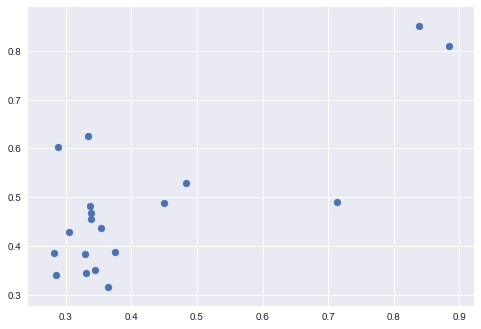

In [339]:
sorted_x = np.argsort(medians)
plt.scatter(np.array(medians)[sorted_x],np.array(x_medians)[sorted_x])

In [6331]:
human_sorted = []
for i in range(len(human_ordered)):
    for j in range(len(human_ordered[i])):
        human_sorted.append(list(human_ordered[i][j]))
print(len(human_sorted))

58


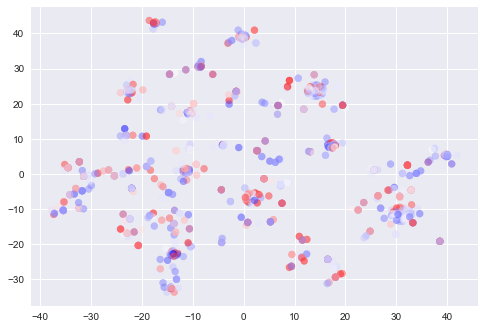

In [6382]:
# overlay sample subtypes ontp tSNE plot
gs = np.array(guanSurvivalDfMMRF.loc[:,"GuanScore"])
gs_index = np.array(guanSurvivalDfMMRF.index)

group = pd.DataFrame(np.median(gs)*np.ones(orderedOverExpressedMembers.shape[1]))
group.index = orderedOverExpressedMembers.columns
group.columns = ["GuanScore"]
group.loc[gs_index,"GuanScore"] = gs
group = np.array(group.iloc[:,0])

plt.scatter(X_embedded[:,0],X_embedded[:,1],cmap="bwr",c=group,alpha=0.5)

In [6360]:
combinatorial_states = []
for hs in human_sorted:
    tmp_df = pd.DataFrame(np.zeros(orderedDM.shape[1]))
    tmp_df.index = orderedDM.columns
    tmp_df.columns = ["status"]
    tmp_df.loc[hs,"status"] = 1
    combinatorial_states.append(np.array(tmp_df.iloc[:,0]))

combinatorial_states = pd.DataFrame(np.vstack(combinatorial_states)) 
combinatorial_states.columns = orderedDM.columns    
combinatorial_states.head() 


MMRF_2644_1_BM  MMRF_2720_1_BM  MMRF_1311_1_BM  MMRF_2539_1_BM  \
0             1.0             0.0             0.0             0.0   
1             0.0             0.0             0.0             0.0   
2             0.0             0.0             0.0             0.0   
3             0.0             0.0             0.0             0.0   
4             0.0             1.0             0.0             0.0   

   MMRF_2055_1_BM  MMRF_2851_1_BM  MMRF_2413_1_BM  MMRF_2400_1_BM  \
0             1.0             1.0             0.0             0.0   
1             0.0             0.0             0.0             0.0   
2             0.0             0.0             1.0             0.0   
3             0.0             0.0             0.0             0.0   
4             0.0             0.0             0.0             0.0   

   MMRF_1501_1_BM  MMRF_2762_1_BM       ...        MMRF_1496_1_PB  \
0             0.0             0.0       ...                   0.0   
1             0.0             0.0       ...                   0.0   
2             0.0             0.0       ...                   0.0   
3             0.0             0.0       ...                   0.0   
4             0.0             1.0       ...                   0.0   

   MMRF_1496_1_BM  MMRF_1078_1_BM  MMRF_2041_1_BM  MMRF_1389_1_BM  \
0             0.0             0.0             0.0             0.0   
1             0.0             0.0             0.0             0.0   
2             0.0             0.0             0.0             0.0   
3             0.0             0.0             0.0             0.0   
4             0.0             0.0             0.0             0.0   

   MMRF_2380_1_BM  MMRF_2373_1_BM  MMRF_2497_1_BM  MMRF_1542_1_BM  \
0             0.0             0.0             0.0             0.0   
1             0.0             0.0             0.0             0.0   
2             0.0             0.0             0.0             0.0   
3             0.0             0.0             0.0             0.0   
4             0.0             0.0             0.0             0.0   

   MMRF_1307_1_BM  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  

[5 rows x 881 columns]

In [6361]:
srv = survivalDfMMRF.copy()
cox_states = miner.parallelMemberSurvivalAnalysis(membershipDf = combinatorial_states,numCores=1,survivalPath="",survivalData=srv)
print(cox_states)

10
20
30


/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) [29] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)
/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) [37] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)


40
50


/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) [51] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)
/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) [54] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)
/Users/MattWall/

{0: (-1.2535129973972838, 0.21001907194648886), 1: (0.3876338374679751, 0.6982870244304624), 2: (1.0526859068918661, 0.29248496985703676), 3: (0.2096614045976344, 0.8339319506367998), 4: (-0.2955687367563304, 0.767559451851688), 5: (-1.3782774155160709, 0.16811765332554973), 6: (0.2811463405971918, 0.7785981592806336), 7: (0.014110680621167682, 0.9887416794010125), 8: (-0.795226562948016, 0.4264817228054363), 9: (-1.5338170109736937, 0.12507467684951573), 10: (3.5733791764904597, 0.0003524038866320426), 11: (-0.016074634536223043, 0.9871748496087631), 12: (-2.5422190355843255, 0.011015112098032253), 13: (-1.810010879371086, 0.07029410005768846), 14: (1.3828128468227399, 0.16672225881374403), 15: (-0.599646209181688, 0.548742044132299), 16: (1.8229702251120452, 0.0683079006191459), 17: (-0.8668021054229613, 0.38605044832380986), 18: (-0.006921386372825485, 0.9944775767662963), 19: (0.8392810827910008, 0.4013115962012551), 20: (-1.398106270033478, 0.16208115730612302), 21: (-0.3964435706

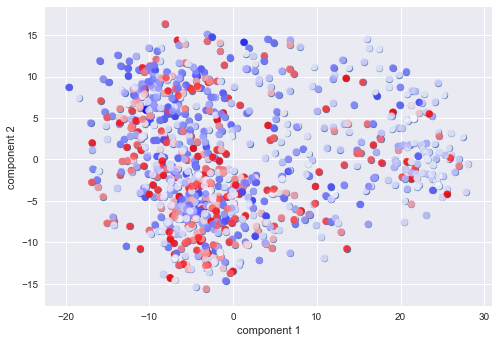

In [6197]:
pca1, pca2 = miner.plotPCA(orderedDM)
plt.scatter(pca1,pca2,cmap="bwr",c=group,alpha=0.85)

# Cox survival based upon binary regulon membership

# Training dataset

In [190]:
# load survival data
survivalMMRF = pd.read_csv(os.path.join("..","data","survivalIA12.csv"),index_col=0,header=0)
survivalDfMMRF = survivalMMRF.iloc[:,0:2]
survivalDfMMRF.columns = ["duration","observed"]
overExpressedMembersMatrixMMRF = overExpressedMembersMatrix
overExpressedMembersMatrixMMRF = overExpressedMembersMatrixMMRF.loc[orderedOverExpressedMembers.index,:]

In [191]:
#generate Kaplan-Meier estimates
kmDf = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfMMRF = miner.guanRank(kmSurvival=kmDf)

# Validation datasets

## Process expression data

In [231]:
# GSE24080UAMS
expressionDataGSE24080UAMS = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","GSE24080UAMSentrezIDlevel.csv"),index_col=0,header=0)
expressionDataGSE24080UAMS, _ = miner.identifierConversion(expressionData=expressionDataGSE24080UAMS)
expressionDataGSE24080UAMS = miner.zscore(expressionDataGSE24080UAMS)
bkgdGSE24080UAMS = miner.backgroundDf(expressionDataGSE24080UAMS)
overExpressedMembersGSE24080UAMS = miner.biclusterMembershipDictionary(regulonModules,bkgdGSE24080UAMS,label=2)
overExpressedMembersMatrixGSE24080UAMS = miner.membershipToIncidence(overExpressedMembersGSE24080UAMS,expressionDataGSE24080UAMS)
overExpressedMembersMatrixGSE24080UAMS = overExpressedMembersMatrixGSE24080UAMS.loc[orderedOverExpressedMembers.index,:]

# GSE19784HOVON65 
expressionDataGSE19784HOVON65 = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","GSE19784HOVON65entrezIDlevel.csv"),index_col=0,header=0)
expressionDataGSE19784HOVON65, _ = miner.identifierConversion(expressionData=expressionDataGSE19784HOVON65)
expressionDataGSE19784HOVON65 = miner.zscore(expressionDataGSE19784HOVON65)
bkgdGSE19784HOVON65 = miner.backgroundDf(expressionDataGSE19784HOVON65)
overExpressedMembersGSE19784HOVON65 = miner.biclusterMembershipDictionary(regulonModules,bkgdGSE19784HOVON65,label=2)
overExpressedMembersMatrixGSE19784HOVON65 = miner.membershipToIncidence(overExpressedMembersGSE19784HOVON65,expressionDataGSE19784HOVON65)
overExpressedMembersMatrixGSE19784HOVON65 = overExpressedMembersMatrixGSE19784HOVON65.loc[orderedOverExpressedMembers.index,:]

# EMTAB4032
expressionDataEMTAB4032 = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","EMTAB4032entrezIDlevel.csv"),index_col=0,header=0)
expressionDataEMTAB4032, _ = miner.identifierConversion(expressionData=expressionDataEMTAB4032)
expressionDataEMTAB4032 = miner.zscore(expressionDataEMTAB4032)
bkgdEMTAB4032 = miner.backgroundDf(expressionDataEMTAB4032)
overExpressedMembersEMTAB4032 = miner.biclusterMembershipDictionary(regulonModules,bkgdEMTAB4032,label=2)
overExpressedMembersMatrixEMTAB4032 = miner.membershipToIncidence(overExpressedMembersEMTAB4032,expressionDataEMTAB4032)
overExpressedMembersMatrixEMTAB4032 = overExpressedMembersMatrixEMTAB4032.loc[orderedOverExpressedMembers.index,:]

completed identifier conversion.
16998 genes were converted.
completed z-transformation.


NameError: name 'bkgdUAMS' is not defined

## Process survival data

In [ ]:
survival = pd.read_csv(os.path.join("..","..","IA12Files","dreamData","globalClinTraining.csv"),index_col=0,header=0)

survivalGSE24080UAMS = survival[survival.index=='GSE24080UAMS']
survivalGSE24080UAMS.index = survivalGSE24080UAMS.iloc[:,0]
survivalGSE24080UAMS.head(3)
survivalDfGSE24080UAMS = survivalGSE24080UAMS.loc[:,["D_PFS","D_PFS_FLAG"]]
survivalDfGSE24080UAMS.columns = ["duration","observed"]

survivalGSE19784HOVON65 = survival[survival.index=='HOVON65']
survivalGSE19784HOVON65.index = survivalGSE19784HOVON65.iloc[:,0]
survivalGSE19784HOVON65.head(3)
survivalDfGSE19784HOVON65 = survivalGSE19784HOVON65.loc[:,["D_PFS","D_PFS_FLAG"]]
survivalDfGSE19784HOVON65.columns = ["duration","observed"]

survivalEMTAB4032 = survival[survival.index=='EMTAB4032']
survivalEMTAB4032.index = survivalEMTAB4032.iloc[:,0]
survivalEMTAB4032.head(3)
survivalDfEMTAB4032 = survivalEMTAB4032.loc[:,["D_PFS","D_PFS_FLAG"]]
survivalDfEMTAB4032.columns = ["duration","observed"]

In [ ]:
#generate Kaplan-Meier estimates
kmDf = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfMMRF = miner.guanRank(kmSurvival=kmDf)

#generate Kaplan-Meier estimates for GuanRank analysis
kmDf = miner.kmAnalysis(survivalDf=survivalDfGSE24080UAMS,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfGSE24080UAMS = miner.guanRank(kmSurvival=kmDf)

#generate Kaplan-Meier estimates for GuanRank analysis
kmDf = miner.kmAnalysis(survivalDf=survivalDfGSE19784HOVON65,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfGSE19784HOVON65 = miner.guanRank(kmSurvival=kmDf)

#generate Kaplan-Meier estimates for GuanRank analysis
kmDf = miner.kmAnalysis(survivalDf=survivalDfEMTAB4032,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfEMTAB4032 = miner.guanRank(kmSurvival=kmDf)

In [5546]:
reload(miner)
Srvs = [guanSurvivalDfMMRF,guanSurvivalDfGSE24080UAMS]
Dfs = [overExpressedMembersMatrixMMRF,overExpressedMembersMatrixGSE24080UAMS]
pred_dict = miner.predictor(Dfs,Srvs,levels=50,numTrials=10,threshold=0.05,override=None,predictorFile = os.path.join(resultsDirectory,"predictor_dictionary_replicate.json"))

3.842174502160378e-24
['5848', '4775', '878', '1837', '5411', '2045', '3381', '3715', '2042', '4']
6.978108661288313e-09
['1784', '301', '4109', '3885', '848', '4347', '4835', '519', '4246', '1600']
3.088571072610624e-13
['5875', '2455', '2723', '92', '1040', '4970', '2593', '2519', '301', '35']
4.536037153526107e-09
['5042', '979', '2747', '2792', '2752', '1793', '3628', '907', '4616', '2470']
1.8836929271179867e-06
['2412', '2747', '4270', '551', '6425', '2831', '500', '3719', '53', '6264']
0.0003598483084183365
['4619', '5530', '2230', '5211', '2428', '1424', '2831', '1985', '3231', '5926']
5.303225337015523e-06
['5287', '2772', '5274', '3291', '4124']
6.916184466917823e-06
['4629', '4964', '1509', '465', '3200', '340', '46']
0.0005916868288061513
['2155']
7.820484617884339e-38
['3175', '1988', '2814', '354', '4418', '1035', '4263']
2.9151752516770165e-07
['4386', '1829', '323']
2.9806793446464217e-05
['90', '5941', '4332', '6357', '5486', '5740']
0.004307387860098149
['279', '4527'

In [5481]:
scoresDf

t-score
MMRF_2754_1_BM  0.175002
MMRF_2151_1_BM  3.882214
MMRF_1634_1_BM  9.854795
MMRF_1450_1_BM  3.882214
MMRF_1778_1_BM  0.000000
MMRF_2115_1_BM  0.000000
MMRF_1851_1_BM  3.882214
MMRF_2272_1_BM  3.882214
MMRF_1270_1_BM  0.000000
MMRF_1598_1_BM  0.000000
MMRF_2739_1_BM  3.882214
MMRF_1540_1_BM  3.882214
MMRF_2843_1_BM  0.000000
MMRF_2847_1_BM  0.175002
MMRF_1720_1_BM  3.882214
MMRF_2300_1_BM  9.854795
MMRF_1671_1_BM  0.000000
MMRF_2444_1_BM  0.175002
MMRF_1716_1_BM  0.175002
MMRF_2401_1_BM  3.882214
MMRF_1654_1_BM  0.175002
MMRF_1284_1_BM  0.175002
MMRF_1231_1_BM  0.000000
MMRF_1641_1_BM  3.882214
MMRF_2379_1_BM  0.000000
MMRF_2490_1_BM  9.854795
MMRF_1738_1_BM  3.882214
MMRF_2314_1_BM  3.882214
MMRF_1944_1_BM  0.175002
MMRF_2251_1_BM  4.650090
...                  ...
MMRF_1395_1_BM  3.882214
MMRF_1380_1_BM  0.000000
MMRF_1371_1_BM  0.000000
MMRF_1323_1_BM  3.882214
MMRF_1318_1_BM  0.000000
MMRF_1266_1_BM  0.000000
MMRF_1304_1_BM  0.000000
MMRF_1312_1_BM  3.882214
MMRF_1355_1_BM  0.000000
MMRF_1393_1_BM  0.175002
MMRF_1325_1_BM  0.000000
MMRF_1311_1_BM  0.000000
MMRF_1386_1_BM  0.000000
MMRF_1184_1_BM  0.000000
MMRF_1098_1_BM  0.000000
MMRF_1159_1_BM  0.000000
MMRF_1185_1_BM  0.175002
MMRF_1128_1_BM  3.882214
MMRF_1073_1_BM  0.000000
MMRF_1307_1_BM  0.000000
MMRF_1211_1_BM  0.175002
MMRF_1171_1_BM  0.000000
MMRF_1235_1_BM  0.000000
MMRF_1274_1_BM  3.882214
MMRF_1290_1_BM  3.882214
MMRF_1310_1_BM  0.000000
MMRF_1314_1_BM  0.175002
MMRF_1048_1_BM  3.882214
MMRF_1086_1_BM  0.000000
MMRF_1030_1_BM  0.000000

[769 rows x 1 columns]

In [6905]:
reload(miner)
df = overExpressedMembersMatrixMMRF.copy()
srv = survivalDfMMRF.copy()
scoresDf = miner.predictorScores(df,srv,pred_dict)
thresholdsMMRF = [5,2,0,-5] #miner.predictorThresholds(scoresDf)
pred_classes = miner.predictClasses(scoresDf,thresholdsMMRF)
survival_tag = "MMRF"
predictor_tag = "mmrf;uams"
srv = guanSurvivalDfMMRF.copy()
print(thresholdsMMRF)

[5, 2, 0, -5]


In [6906]:
vhr_ = list(pred_classes.index[np.where(pred_classes.iloc[:,0]==5)[0]])
vlr_ = list(pred_classes.index[np.where(pred_classes.iloc[:,0]==1)[0]])
hr_ = list(pred_classes.index[np.where(pred_classes.iloc[:,0]==4)[0]])
lr_ = list(pred_classes.index[np.where(pred_classes.iloc[:,0]==2)[0]])
avg_ = list(pred_classes.index[np.where(pred_classes.iloc[:,0]==3)[0]])
total = float(len(vhr_)+len(hr_)+len(avg_)+len(lr_)+len(vlr_))
print(len(vhr_)/total,len(hr_)/total,len(avg_)/total,len(lr_)/total,len(vlr_)/total)

(0.10013003901170352, 0.14954486345903772, 0.10403120936280884, 0.1508452535760728, 0.49544863459037713)


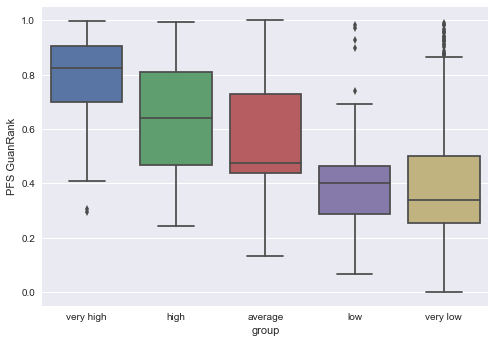

In [6907]:
guan_srv = pd.DataFrame(srv.loc[:,"GuanScore"])
guan_srv.columns = ["value"]
guan_srv_group = pd.DataFrame(np.zeros(guan_srv.shape[0]))
guan_srv_group.index = guan_srv.index
guan_srv_group.columns = ["group"]
guan_srv_df = pd.concat([guan_srv,guan_srv_group],axis=1)


groups = [vhr_,hr_,avg_,lr_,vlr_]
labels = ["very high","high","average","low","very low"]
for i in range(len(groups)):
    group = groups[i]
    label = labels[i]
    guan_srv_df.loc[group,"group"] = label
    
import seaborn as sns
sns.boxplot(x='group', y='value', data=guan_srv_df,order=labels)
plt.ylabel("PFS GuanRank")
boxplotFilename = ("_").join([survival_tag,predictor_tag,"boxplot.pdf"])
plt.savefig(os.path.join(resultsDirectory,boxplotFilename),bbox_inches="tight")
#sns.stripplot(x='group', y='value', data=guan_srv_df,order=labels,color="orange", jitter=0.2, size=2.5)

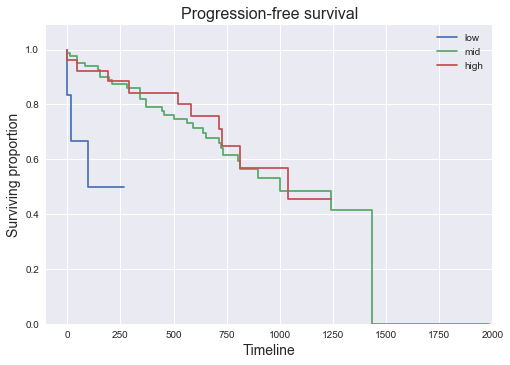

In [520]:
reload(miner)
kmTag = "742"
#kmFilename = ("_").join([survival_tag,predictor_tag,kmTag,".pdf"])
groups = [low_742,mid_742,high_742]
labels = ["low","mid","high"]
#plotName = os.path.join(resultsDirectory,kmFilename)
miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,2000),filename=None)    

In [5616]:
groups = [vhr_,hr_,avg_,lr_,vlr_]
labels = ["very high","high","average","low","very low"]
cox_vectors = []
srv_set = set(srv.index)
for i in range(len(groups)):
    group = groups[i]
    patients = list(set(group)&srv_set)
    tmp_df = pd.DataFrame(np.zeros(srv.shape[0]))
    tmp_df.index = srv.index
    tmp_df.columns = [labels[i]]
    tmp_df.loc[patients,labels[i]] = 1
    cox_vectors.append(tmp_df)
    
pre_cox = pd.concat(cox_vectors,axis=1).T
pre_cox.head(5)
    
cox_dict = miner.parallelMemberSurvivalAnalysis(membershipDf = pre_cox,numCores=1,survivalPath="",survivalData=srv)
print(cox_dict)

/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) ['very high'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)
/Users/MattWall/anaconda/lib/python2.7/site-packages/lifelines/utils/__init__.py:981: RuntimeWarning: Complete seperation possibly detected. Column(s) ['high'] have very low variance. This may harm convergence. Try dropping this redundant column before fitting if convergence fails. See https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faqwhat-is-complete-or-quasi-complete-separation-in-logisticprobit-regression-and-how-do-we-deal-with-them/
  warnings.warn(warning_text, RuntimeWarning)
/Us

{'high': (1.269749350905666, 0.20417392749262686), 'very high': (1.8875215381843686, 0.05909021220608225), 'average': (-0.19634002612550783, 0.8443440347063036), 'low': (-1.2704608422528836, 0.20392052263481247), 'very low': (-0.5534058423516598, 0.579985539246644)}


# Generate inputs for causal analysis

In [3356]:
reload(miner)
miner.generateCausalInputs(expressionData,mechanisticOutput,coexpressionModules,saveFolder=resultsDirectory,regulon_dict=regulons,mutationFile="translocationsIA12.csv")    

# Pause to run NEO using the minerNEO notebook

# Continue to generate causal mechanistic network

In [3360]:
# After running NEO (in R), proceed with the following
preProcessedCausalResults = miner.processCausalResults(causalPath=os.path.join("..","results","causal"))
# load complete mutation matrix with default filters for use in postprocessing
filteredMutations = miner.mutationMatrix(mutationPath=os.path.join(os.path.expanduser("~"),"Desktop","miner","data"),mutationFiles = ["filteredMutationsIA12.csv","translocationsIA12.csv"],minNumMutations=None)
# load tf expression matrix for use in postprocessing
tfExp = miner.tfExpression(expressionData,motifPath=os.path.join("..","data","all_tfs_to_motifs.pkl"))
# load eigengenes matrix for use in postprocessing
eigengenes = pd.read_csv(os.path.join(os.path.expanduser("~"),"Desktop","miner","results","eigengenes.csv"),index_col=0,header=0)
# generate p values for all network edges for use in filtering
postProcessedCausalAnalysis = miner.postProcessCausalResults(preProcessedCausalResults,filteredMutations,tfExp,eigengenes,mechanisticOutput=None,numCores=5)
# write post-processed analysis to json file       
miner.write_json(postProcessedCausalAnalysis,os.path.join(os.path.expanduser("~"),"Desktop","miner","results","regulonNetworkPValues.json"))     
# generate causal mechanistic network in dataframe format
causalMechanisticNetwork = miner.causalMechanisticNetworkDictionary(postProcessedCausalAnalysis,biclusterRegulatorPvalue=0.05,regulatorMutationPvalue=0.05,mutationFrequency = 0.01,requireCausal=True)
# save causalMechanisticNetwork to csv
causalMechanisticNetwork.to_csv(os.path.join(os.path.expanduser("~"),"Desktop","miner","results","regulonCausalMechanisticNetwork.csv"))


0
0
0
0
10
0
10
10
20
20
30
10
10
20
30
30
20
40
40
50
30
60
50
70
40
20
60
80
70
50
90
60
80
40
100
70
90
110
80
100
120
30
110
90
130
50
100
120
140
40
110
120
60
130
130
150
140
140
150
160
160
50
150
170
170
70
160
180
170
190
180
60
180
200
80
210
190
190
220
200
230
70
200
210
240
90
210
220
220
250
230
230
260
100
80
240
250
110
240
270
260
90
270
280
120
250
290
280
130
260
140
300
270
150
280
310
290
100
320
290
160
300
330
300
340
350
310
170
310
320
110
320
180
330
330
340
360
340
190
370
350
200
380
120
350
390
360
400
210
370
410
360
220
380
420
370
230
430
390
400
380
240
130
410
250
440
260
390
450
420
460
270
400
470
140
480
430
410
280
420
440
490
430
500
450
510
290
460
150
440
450
470
300
460
480
160
470
520
490
480
500
510
490
310
520
500
530
530
510
540
170
520
550
530
540
550
540
560
550
570
320
180
560
560
580
570
330
590
580
340
570
190
600
590
350
610
600
620
360
580
610
630
370
200
620
640
380
590
630
650
210
390
600
660
640
400
650
660
610
410
620
420
430
220

In [3361]:
causalMechanisticNetwork.head(10)

Cluster        Regulator RegulatorToClusterEdge RegulatorToClusterPValue  \
0        0  ENSG00000112561                     -1    8.254707075053736e-07   
5        1  ENSG00000134954                      1    4.282516608765101e-06   
8        1  ENSG00000112561                     -1    9.928461308078495e-06   
10       1  ENSG00000150347                      1    9.674711543824073e-11   
20       2  ENSG00000112561                     -1   2.7987456080179917e-06   
24       2  ENSG00000100219                     -1   1.3920579356328887e-07   
27       3  ENSG00000178951                      1   3.3718431941610238e-06   
29       4  ENSG00000185022                     -1    8.922009465237698e-06   
35       7  ENSG00000269404                      1    4.186634953531434e-06   
36       8  ENSG00000178951                     -1    9.687395543799073e-06   

   RegulatorBindingSiteEnrichment          Mutation MutationToRegulatorEdge  \
0                           1e-10            ZNF727                      -1   
5                           1e-10  RNASeq_MAFA_Call                       1   
8                           1e-10            ZNF727                      -1   
10                          1e-10              NRAS                      -1   
20                          1e-10            ZNF727                      -1   
24                          1e-10             MXRA5                      -1   
27                          1e-10             WDR90                      -1   
29                          1e-10             KCNB1                       1   
35                          1e-10               MYC                       1   
36                          1e-10              SVIL                      -1   

   MutationToRegulatorPValue FrequencyOfMutation  
0        0.04962412309726247     0.0136208853575  
5      6.495343036587598e-06     0.0124858115778  
8        0.04962412309726247     0.0136208853575  
10      0.029861419714034828      0.208853575482  
20       0.04962412309726247     0.0136208853575  
24      0.013484330897574866     0.0261066969353  
27      0.012968451588445538     0.0124858115778  
29      0.029138535294976748     0.0147559591373  
35       0.00206736180456369     0.0147559591373  
36       0.04844346756704692     0.0215664018161

# Investigate risk signatures

In [3294]:
reload(miner)                        
riskSignatures = miner.splitRiskSignatures(pred_dict,thresholds=thresholdsMMRF)               

In [3295]:
riskSignatures["very low"]

[['4561', '3897', '3883', '1887', '1979', '4560', '236'],
 ['3732', '3270', '4228', '5480', '5151', '1309', '4084', '34'],
 ['1314', '3382', '1965', '3350', '3544'],
 ['1611', '4993', '241'],
 ['3732', '5273', '5715', '6357', '5516', '1311', '2782', '243'],
 ['3786', '3330', '2821'],
 ['5699', '5870', '5862', '338'],
 ['1902', '3373', '4826', '6368', '5917'],
 ['1815', '3694', '1680'],
 ['1025', '1678', '323'],
 ['198', '2429']]

In [3296]:
veryLowBiclusters = np.hstack(riskSignatures["very low"])
print(veryLowBiclusters)

['4561' '3897' '3883' '1887' '1979' '4560' '236' '3732' '3270' '4228'
 '5480' '5151' '1309' '4084' '34' '1314' '3382' '1965' '3350' '3544'
 '1611' '4993' '241' '3732' '5273' '5715' '6357' '5516' '1311' '2782'
 '243' '3786' '3330' '2821' '5699' '5870' '5862' '338' '1902' '3373'
 '4826' '6368' '5917' '1815' '3694' '1680' '1025' '1678' '323' '198'
 '2429']


In [3307]:
vlr_genepool = np.array(np.hstack([regulonModules[key] for key in veryLowBiclusters]))
gene_count = Counter(vlr_genepool)
ranked_genes = gene_count.most_common()
core_genes = [g[0] for g in ranked_genes[100:200]]
np.savetxt(os.path.join(resultsDirectory,"core_genes.txt"),core_genes,fmt="%1.50s")

In [3311]:
lens = [len(regulonModules[key]) for key in veryLowBiclusters]
print(lens)

[347, 51, 92, 162, 185, 373, 472, 246, 118, 147, 156, 29, 116, 27, 119, 194, 221, 170, 129, 145, 126, 107, 315, 246, 128, 395, 222, 244, 350, 547, 306, 63, 89, 352, 38, 84, 76, 227, 72, 241, 333, 142, 147, 42, 132, 287, 105, 221, 88, 98, 84]


In [3319]:
core_genes = regulonModules['1680']
print(len(core_genes))
np.savetxt(os.path.join(resultsDirectory,"core_genes.txt"),core_genes,fmt="%1.50s")

287


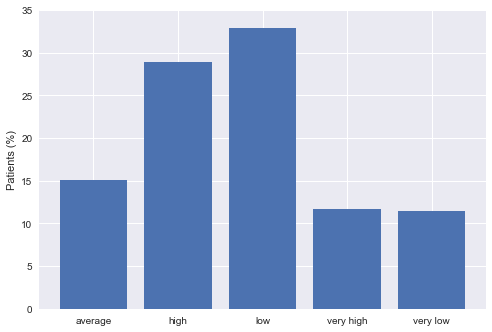

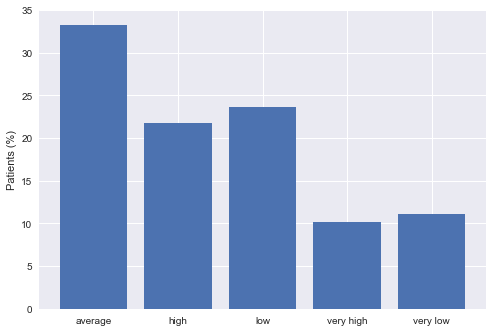

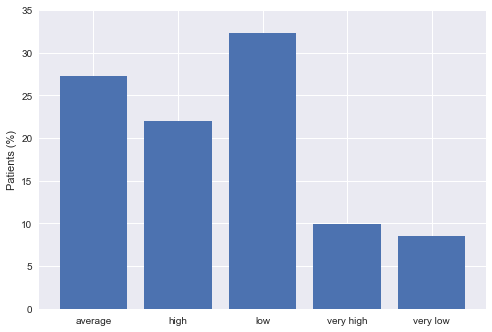

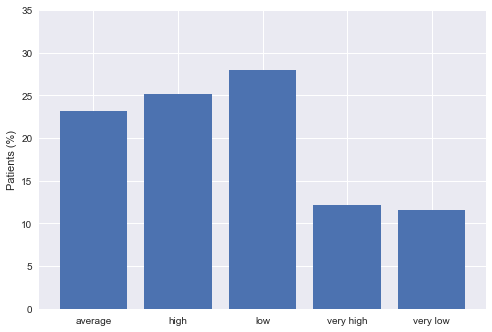

In [3331]:
#bar graph for proportions:
#labels = ["very high","high","average","low","very low"]
proportions_mmrf = [11.7,28.9,15.1,32.9,11.4]
proportions_uams = [10.2,21.8,33.2,23.6,11.1]
proportions_hovon = [9.9,22.0,27.3,32.3,8.5]
proportions_emtab = [12.2,25.2,23.1,27.9,11.6]

barFilename = "barplot"

plt.figure()
plt.bar(labels,proportions_mmrf)
plt.ylabel("Patients (%)")
ax = plt.gca()
ax.set_ylim(0,35)
plt.savefig(os.path.join(resultsDirectory,("_").join([barFilename,"mmrf.pdf"])),bbox_inches="tight")
plt.figure()
plt.bar(labels,proportions_uams)
plt.ylabel("Patients (%)")
ax = plt.gca()
ax.set_ylim(0,35)
plt.savefig(os.path.join(resultsDirectory,("_").join([barFilename,"uams.pdf"])),bbox_inches="tight")
plt.figure()
plt.bar(labels,proportions_hovon)
plt.ylabel("Patients (%)")
ax = plt.gca()
ax.set_ylim(0,35)
plt.savefig(os.path.join(resultsDirectory,("_").join([barFilename,"hovon65.pdf"])),bbox_inches="tight")
plt.figure()
plt.bar(labels,proportions_emtab)
plt.ylabel("Patients (%)")
ax = plt.gca()
ax.set_ylim(0,35)
plt.savefig(os.path.join(resultsDirectory,("_").join([barFilename,"emtab4032.pdf"])),bbox_inches="tight")

In [3341]:
print(len(vlr_))

62


In [3340]:
srv.loc[vlr_,:]

duration  observed  kmEstimate  GuanScore
Patient                                                
GSM592392  2954.433333         0    0.290829   0.144779
GSM592395  1301.333333         1    0.641463   0.643509
GSM592400  2824.300000         1    0.290829   0.291351
GSM592412  2827.350000         0    0.290829   0.144779
GSM592675  2594.533333         0    0.387773   0.193562
GSM592680  2407.466667         0    0.399523   0.199467
GSM592706  2534.550000         0    0.387773   0.193562
GSM592709  2509.133333         0    0.387773   0.193562
GSM592749  2311.900000         0    0.451636   0.225645
GSM592814  2006.900000         0    0.503706   0.251787
GSM592823  1991.650000         0    0.509496   0.254693
GSM592827  1998.766667         0    0.509496   0.254693
GSM592844  1948.950000         0    0.520284   0.260107
GSM592848  1931.666667         0    0.520284   0.260107
GSM592851  1757.816667         0    0.540294   0.270149
GSM592855  1865.583333         0    0.540294   0.270149
GSM592857  1805.600000         0    0.540294   0.270149
GSM592877  1865.583333         0    0.540294   0.270149
GSM592878  1835.083333         0    0.540294   0.270149
GSM592897  1553.466667         0    0.578866   0.289501
GSM592900  1657.166667         0    0.555451   0.277754
GSM592903  1627.683333         0    0.565932   0.283013
GSM592905  1706.983333         0    0.551821   0.275932
GSM592910  1716.133333         0    0.548041   0.274036
GSM592911  1721.216667         0    0.548041   0.274036
GSM592913  1627.683333         0    0.565932   0.283013
GSM592914  1594.133333         0    0.572572   0.286344
GSM592920  1652.083333         0    0.555451   0.277754
GSM592924  1589.050000         0    0.572572   0.286344
GSM592934  1619.550000         0    0.565932   0.283013
...                ...       ...         ...        ...
GSM592435  1598.200000         0    0.572572   0.286344
GSM592445  1570.750000         0    0.575753   0.287940
GSM592446  1574.816667         0    0.572572   0.286344
GSM592447  1557.533333         0    0.578866   0.289501
GSM592449  1602.266667         0    0.569301   0.284703
GSM592466  1459.933333         0    0.601386   0.300807
GSM592467  1372.500000         0    0.624618   0.312466
GSM592470  1500.600000         0    0.584803   0.292480
GSM592474  1378.600000         0    0.622109   0.311208
GSM592475  1407.066667         0    0.614533   0.307401
GSM592476  1484.333333         0    0.590439   0.295307
GSM592480  1459.933333         0    0.601386   0.300807
GSM592483  1487.383333         0    0.587628   0.293897
GSM592486  1527.033333         0    0.584803   0.292480
GSM592487  1500.600000         0    0.584803   0.292480
GSM592503  1336.916667         0    0.629566   0.314948
GSM592506  1411.133333         0    0.614533   0.307401
GSM592520  1393.850000         0    0.617072   0.308675
GSM592527  1372.500000         0    0.624618   0.312466
GSM592529  1347.083333         0    0.629566   0.314948
GSM592555  1241.350000         0    0.662081   0.331260
GSM592580  1193.566667         0    0.668615   0.334537
GSM592590  1165.100000         0    0.677126   0.338805
GSM592591  1130.533333         0    0.685428   0.342968
GSM592592  1110.200000         0    0.695598   0.348072
GSM592631  1038.016667         0    0.715420   0.358011
GSM592638  1072.583333         0    0.705656   0.353115
GSM592639  1012.600000         0    0.723026   0.361824
GSM592653   956.683333         0    0.743602   0.372140
GSM592654   960.750000         0    0.741756   0.371215

[62 rows x 4 columns]

In [3386]:
np.array(causalMechanisticNetwork[causalMechanisticNetwork.Cluster=="1"].Regulator)

array(['ENSG00000134954', 'ENSG00000112561', 'ENSG00000150347'],
      dtype=object)

In [3413]:
vlr_biclusters = np.hstack(riskSignatures["very low"])
vlr_regulators = []
vlr_mutations = []
for bc in vlr_biclusters:
    vlr_regulators.extend(np.array(causalMechanisticNetwork[causalMechanisticNetwork.Cluster==bc].Regulator))
    vlr_mutations.extend(np.array(causalMechanisticNetwork[causalMechanisticNetwork.Cluster==bc].Mutation))    

In [3414]:
mutation_count = Counter(vlr_mutations)
mutation_rank = mutation_count.most_common()
regulator_count = Counter(vlr_regulators)
regulator_rank = regulator_count.most_common()

In [3416]:
mutation_rank
#regulator_rank

[('FAT3', 3),
 ('RNASeq_WHSC1_Call', 3),
 ('TACC2', 2),
 ('GPR158', 2),
 ('BRWD3', 2),
 ('PRKD2', 2),
 ('TRAF2', 1),
 ('HUWE1', 1),
 ('ZMYM6', 1),
 ('RNASeq_MAF_Call', 1),
 ('ZNF727', 1),
 ('TGDS', 1),
 ('MAX', 1),
 ('TNS3', 1),
 ('MXRA5', 1),
 ('ZNF462', 1),
 ('ZNF415', 1),
 ('KCNB1', 1)]

In [3423]:
vhr_

['MMRF_1634_1_BM',
 'MMRF_1450_1_BM',
 'MMRF_1778_1_BM',
 'MMRF_2272_1_BM',
 'MMRF_2739_1_BM',
 'MMRF_1540_1_BM',
 'MMRF_2300_1_BM',
 'MMRF_2401_1_BM',
 'MMRF_2490_1_BM',
 'MMRF_2251_1_BM',
 'MMRF_1107_1_BM',
 'MMRF_1910_1_BM',
 'MMRF_2557_1_BM',
 'MMRF_1890_1_BM',
 'MMRF_2290_1_BM',
 'MMRF_1668_1_BM',
 'MMRF_2722_1_BM',
 'MMRF_2562_1_BM',
 'MMRF_2621_1_BM',
 'MMRF_1912_1_PB',
 'MMRF_1587_1_BM',
 'MMRF_1361_1_BM',
 'MMRF_2781_1_BM',
 'MMRF_1897_1_BM',
 'MMRF_1082_1_BM',
 'MMRF_2455_1_BM',
 'MMRF_2089_1_BM',
 'MMRF_2106_1_BM',
 'MMRF_1790_1_BM',
 'MMRF_1432_1_BM',
 'MMRF_1252_1_BM',
 'MMRF_2720_1_BM',
 'MMRF_2039_1_BM',
 'MMRF_1496_1_BM',
 'MMRF_1335_1_BM',
 'MMRF_2535_1_BM',
 'MMRF_2172_1_BM',
 'MMRF_1320_1_BM',
 'MMRF_1415_1_BM',
 'MMRF_1501_1_BM',
 'MMRF_1815_1_BM',
 'MMRF_1974_1_BM',
 'MMRF_1491_1_BM',
 'MMRF_1289_1_BM',
 'MMRF_1656_1_BM',
 'MMRF_2394_1_BM',
 'MMRF_2531_1_BM',
 'MMRF_1490_1_BM',
 'MMRF_1771_1_BM',
 'MMRF_1531_1_BM',
 'MMRF_2015_1_BM',
 'MMRF_1542_1_BM',
 'MMRF_2225_

In [3431]:
riskSubtypeMutationFrequencies = {}
groups = [vhr_,hr_,avg_,lr_,vlr_]
labels = ["very high","high","average","low","very low"]
for i in range(len(groups)):
    group = groups[i]
    label = labels[i]
    riskSubtypeMutationFrequencies[label] = filteredMutations.loc[:,group].sum(axis=1)/float(len(group))

In [3461]:
differential_risk = riskSubtypeMutationFrequencies["very low"]-0.25*(riskSubtypeMutationFrequencies["very high"]+riskSubtypeMutationFrequencies["high"]+riskSubtypeMutationFrequencies["low"]+riskSubtypeMutationFrequencies["average"])

In [3462]:
differential_risk.sort_values()

RNASeq_FGFR3_Call   -0.064912
RNASeq_WHSC1_Call   -0.059355
LTB                 -0.042925
ZNF462              -0.038555
TP53                -0.038198
PKHD1               -0.037231
LRP1B               -0.036582
KRAS                -0.032801
EGR1                -0.031009
FREM2               -0.030669
LRP2                -0.029882
RYR2                -0.029790
CREBBP              -0.028308
SETD2               -0.027519
ZFHX3               -0.027328
DIS3                -0.027249
MUC16               -0.026769
CSMD1               -0.026270
GPR98               -0.026189
PKHD1L1             -0.025005
SVEP1               -0.022787
PCDH15              -0.022586
UNC13C              -0.021832
ZAN                 -0.021620
HMCN1               -0.021186
SPEF2               -0.020679
HIVEP1              -0.020657
BMP2K               -0.020396
SALL3               -0.020340
REV3L               -0.020023
                       ...   
RNF133               0.029862
AP3B2                0.030000
HIST1H1E  

In [3441]:
mut_freq = filteredMutations.sum(axis=1)/filteredMutations.shape[1]

In [3949]:
riskSubtypeMutationFrequencies["very low"]

KRAS                 0.215909
NRAS                 0.250000
TTN                  0.102273
DIS3                 0.079545
FAM46C               0.090909
MUC16                0.056818
TRAF3                0.090909
BRAF                 0.090909
PCLO                 0.045455
FAT3                 0.068182
CSMD3                0.068182
TP53                 0.011364
RYR2                 0.034091
LRP1B                0.022727
FAT4                 0.090909
FAT1                 0.090909
RYR1                 0.056818
FLG                  0.034091
FSIP2                0.034091
DNAH5                0.045455
USH2A                0.079545
EGR1                 0.011364
DUSP2                0.090909
HIST1H1E             0.068182
GPR98                0.011364
ATM                  0.011364
ZFHX4                0.045455
HMCN1                0.022727
SYNE1                0.056818
HUWE1                0.056818
                       ...   
SLC24A2              0.000000
HDAC4                0.000000
SEMA3C    

In [3955]:
vlr_t414 = filteredMutations.columns[np.where(filteredMutations.loc["RNASeq_WHSC1_Call",vlr_]==1)[0]]

In [3957]:
sumTest414 = filteredMutations.loc[:,vlr_t414].sum(axis=1)
sumTest414.sort_values()

TBC1D8      0.0
CDHR2       0.0
GNAQ        0.0
TRANK1      0.0
C3orf30     0.0
PTK2        0.0
KRT76       0.0
DAAM2       0.0
PHRF1       0.0
STRN        0.0
KIAA0556    0.0
SLC44A5     0.0
FHOD3       0.0
ZFP36L2     0.0
PIKFYVE     0.0
ARHGAP28    0.0
CCDC171     0.0
SLCO1B7     0.0
CDK8        0.0
RNF133      0.0
ZSCAN1      0.0
NPTX2       0.0
DLGAP1      0.0
GGA2        0.0
MICAL3      0.0
SAFB        0.0
APP         0.0
TRIM41      0.0
TRIM42      0.0
HTR2C       0.0
           ... 
CACNA1E     1.0
NDST4       1.0
MFHAS1      1.0
EEF1A1      1.0
CACNB2      1.0
DSCAM       1.0
DDX60       1.0
SP3         1.0
PTPN13      1.0
KIAA1598    1.0
ANXA1       1.0
PPP1R21     1.0
ANKRD11     1.0
CARD11      1.0
TMC1        1.0
OGT         1.0
SASH1       1.0
RIMS2       1.0
NRP2        1.0
ASCC3       1.0
KMT2C       1.0
ITGAV       1.0
LAMA3       1.0
LAMA5       1.0
MYH2        1.0
KLHL6       1.0
MTMR2       1.0
KRAS        1.0
MUC16       2.0
TTN         2.0
Length: 1746, dtype: flo

In [3958]:
filteredMutations.loc["RNASeq_WHSC1_Call",vlr_t414]

MMRF_1029_1_BM    0.0
MMRF_1030_1_BM    0.0
MMRF_1085_3_BM    0.0
MMRF_1128_1_BM    0.0
MMRF_1130_1_BM    0.0
MMRF_1137_1_BM    0.0
MMRF_1184_1_BM    0.0
MMRF_1229_1_BM    0.0
MMRF_1229_2_BM    0.0
Name: RNASeq_WHSC1_Call, dtype: float64